# Visualization of Conv-BiLSTM Model Results on UKDLAE Dataset for NILM Task

**The model was inspired by the paper *Neural NILM: Deep Neural Networks Applied to Energy Disaggregation***

### Importing Necessary Libraries

This part sets up the environment and imports necessary libraries for building and evaluating a deep learning model for power consumption prediction using NILM (Non-Intrusive Load Monitoring).

In [1]:
from __future__ import print_function
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from collections import defaultdict, OrderedDict
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, mean_absolute_error, matthews_corrcoef, mean_squared_error

import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd
import time

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


# Ignore all warnings
warnings.filterwarnings('ignore')

### Reading the UKDALE Dataset

Now, we opens an HDF5 file containing the UK-DALE dataset in read mode using pandas for upcoming preprocessing steps.

In [2]:
store = pd.HDFStore('../ukdale/ukdale.h5', mode='r')

### UKDALE Dataset Preprocessing

**The main objective of this part is to prepare and preprocess the dataset for upcoming model training and splitting. This function resamples power consumption data and fills missing values.**

In [3]:
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=1000.):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s<10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert('UTC')

In [4]:
def get_series(datastore, house, label, cutoff):
    filename = '../ukdale/house_%1d_labels.dat' %house
    print(filename)
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]

    for i in labels:
        if labels[i] == label:
            print(i, labels[i])
            s = resample_meter(store, house, i, '1min', cutoff)

    s.index.name = 'datetime'
    
    return s

**In the following cells, we simply retrieves and preprocesses power consumption data for our target appliances appliances in houses 1, 2, 3, 4, and 5.**

In [5]:
house = 1
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'

ds_1 = pd.concat([m, a2, a3, a5], axis=1)
ds_1.fillna(method='pad', inplace=True)

ds_1_train = ds_1[pd.to_datetime('2013-04-12 00:00:00+00:00'):pd.to_datetime('2014-12-15 00:00:00+00:00')]
ds_1_valid = ds_1[pd.to_datetime('2014-12-15 00:00:00+00:00'):]

../ukdale/house_1_labels.dat
1 aggregate
../ukdale/house_1_labels.dat
10 kettle
../ukdale/house_1_labels.dat
12 fridge
../ukdale/house_1_labels.dat
5 washing_machine
../ukdale/house_1_labels.dat
13 microwave
../ukdale/house_1_labels.dat
6 dishwasher


In [6]:
house = 2
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a5 = get_series(store, house, 'dish_washer', 2500.)
a5.name = 'dish_washer'

ds_2 = pd.concat([m,a2,a3,a5], axis=1)
ds_2.fillna(method='pad', inplace=True)

ds_2_train = ds_2[pd.to_datetime('2013-05-22 00:00:00+00:00'):pd.to_datetime('2013-10-03 00:00:00+00:00')]
ds_2_valid = ds_2[pd.to_datetime('2013-10-03 00:00:00+00:00'):]

../ukdale/house_2_labels.dat
1 aggregate
../ukdale/house_2_labels.dat
8 kettle
../ukdale/house_2_labels.dat
14 fridge
../ukdale/house_2_labels.dat
12 washing_machine
../ukdale/house_2_labels.dat
15 microwave
../ukdale/house_2_labels.dat
13 dish_washer


In [7]:
house = 3
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a2 = 0.*m
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a5 = 0.*m
a5.name = 'dish_washer'
    
ds_3 = pd.concat([m,a2,a3,a5], axis=1)
ds_3.fillna(method='pad', inplace=True)

ds_3_train = ds_3[pd.to_datetime('2013-02-27 00:00:00+00:00'):pd.to_datetime('2013-04-01 00:00:00+00:00')]
ds_3_valid = ds_3[pd.to_datetime('2013-04-01 00:00:00+00:00'):]

../ukdale/house_3_labels.dat
1 aggregate
../ukdale/house_3_labels.dat
2 kettle


In [8]:
house = 4
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a2 = get_series(store, house, 'freezer', 300.)
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a5 = 0.*m
a5.name = 'dish_washer'

ds_4 = pd.concat([m,a2, a3,a5], axis=1)
ds_4.fillna(method='pad', inplace=True)

ds_4_train = ds_4[pd.to_datetime('2013-03-09 00:00:00+00:00'):pd.to_datetime('2013-09-24 00:00:00+00:00')]
ds_4_valid = ds_4[pd.to_datetime('2013-09-24 00:00:00+00:00'):]

../ukdale/house_4_labels.dat
1 aggregate
../ukdale/house_4_labels.dat
3 kettle_radio
../ukdale/house_4_labels.dat
5 freezer


In [9]:
house = 5
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a2 = get_series(store, house, 'fridge_freezer', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washer_dryer', 2500.)
a3.name = 'washing_machine'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
    
ds_5 = pd.concat([m,a2,a3,a5], axis=1)
ds_5.fillna(method='pad', inplace=True)

ds_5_train = ds_5[pd.to_datetime('2014-06-29 00:00:00+00:00'):pd.to_datetime('2014-09-1 00:00:00+00:00')]
ds_5_valid = ds_5[pd.to_datetime('2014-09-1 00:00:00+00:00'):]

../ukdale/house_5_labels.dat
1 aggregate
../ukdale/house_5_labels.dat
18 kettle
../ukdale/house_5_labels.dat
19 fridge_freezer
../ukdale/house_5_labels.dat
24 washer_dryer
../ukdale/house_5_labels.dat
23 microwave
../ukdale/house_5_labels.dat
22 dishwasher


**Saving the data in feather files.**

In [10]:
ds_1_train.reset_index().to_feather('../UKDALE_1_train.feather')
ds_2_train.reset_index().to_feather('../UKDALE_2_train.feather')
ds_3_train.reset_index().to_feather('../UKDALE_3_train.feather')
ds_4_train.reset_index().to_feather('../UKDALE_4_train.feather')
ds_5_train.reset_index().to_feather('../UKDALE_5_train.feather')

ds_1_valid.reset_index().to_feather('../UKDALE_1_valid.feather')
ds_2_valid.reset_index().to_feather('../UKDALE_2_valid.feather')
ds_3_valid.reset_index().to_feather('../UKDALE_3_valid.feather')
ds_4_valid.reset_index().to_feather('../UKDALE_4_valid.feather')
ds_5_valid.reset_index().to_feather('../UKDALE_5_valid.feather')

### Splitting the dataset into Training, Validation, and Testing

**The following code is for retruning the working status of the target appliances (ON/OFF) based on the power consumption and the type of the appliance.**

In [12]:
def get_status(app, threshold, min_off, min_on):
    condition = app > threshold
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    on_events = idx[:,0].copy()
    off_events = idx[:,1].copy()
    assert len(on_events) == len(off_events)

    if len(on_events) > 0:
        off_duration = on_events[1:] - off_events[:-1]
        off_duration = np.insert(off_duration, 0, 1000.)
        on_events = on_events[off_duration > min_off]
        off_events = off_events[np.roll(off_duration, -1) > min_off]
        assert len(on_events) == len(off_events)

        on_duration = off_events - on_events
        on_events = on_events[on_duration > min_on]
        off_events = off_events[on_duration > min_on]

    s = app.copy()
    #s.iloc[:] = 0.
    s[:] = 0.

    for on, off in zip(on_events, off_events):
        #s.iloc[on:off] = 1.
        s[on:off] = 1.
    
    return s

**For this Power class, we are using it for normalizing the power consumption of the target appliances by deviding the values by a refrence power (max_power).**

In [13]:
class Power(data.Dataset):
    def __init__(self, meter=None, appliance=None, status=None, 
                 length=256, border=680, max_power=1., train=False):
        self.length = length
        self.border = border
        self.max_power = max_power
        self.train = train

        self.meter = meter.copy()/self.max_power
        self.appliance = appliance.copy()/self.max_power
        self.status = status.copy()

        self.epochs = (len(self.meter) - 2*self.border) // self.length

    def __getitem__(self, index):
        i = index * self.length + self.border
        if self.train:
            i = np.random.randint(self.border, len(self.meter) - self.length - self.border)

        x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.status.iloc[i:i+self.length].values.astype('float32')

        return x, y, s

    def __len__(self):
        return self.epochs
    
    def denormalize(self):
        self.meter *= self.max_power
        self.appliance *= self.max_power

**Here, we are intializing different paramters, such as the input sequence length, the batch size, etc.**

In [17]:
APPLIANCE = ['fridge', 'dish_washer', 'washing_machine']
THRESHOLD = [50., 10., 20.]
MIN_ON = [1., 30., 30.]
MIN_OFF = [1., 30., 3.]

METER = 'aggregate'
SEQ_LEN = 60*8
BORDER = 16
BATCH_SIZE = 32

MAX_POWER = 2000.

In [18]:
ds_meter = []
ds_appliance = []
ds_status = []
for i in range(5):
    ds = pd.read_feather('../UKDALE_%d_train.feather' %(i+1))
    ds.set_index('datetime', inplace=True)
    
    meter = ds[METER]
    appliances = ds[APPLIANCE]
    
    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)
    
    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)

ds_len = [len(ds_meter[i]) for i in range(5)]

In [19]:
(ds_status[1].diff()==1).sum()

fridge             3515
dish_washer          98
washing_machine      54
dtype: int64

In [20]:
ds_status[1].describe()

,fridge,dish_washer,washing_machine
count,192961.000000,192961.000000,192961.000000
mean,0.378014,0.028975,0.011339
std,0.484892,0.167736,0.105880
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


**This code creates training, validation, and test datasets from power consumption data for multiple houses, and sets up data loaders for model training and evaluation.**

In [21]:
ds_house_train = [Power(ds_meter[i][:int(0.8*ds_len[i])], 
                        ds_appliance[i][:int(0.8*ds_len[i])], 
                        ds_status[i][:int(0.8*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        ds_appliance[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])],
                        ds_status[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_test  = [Power(ds_meter[i][int(0.9*ds_len[i]):], 
                        ds_appliance[i][int(0.9*ds_len[i]):],
                        ds_status[i][int(0.9*ds_len[i]):], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_total  = [Power(ds_meter[i], ds_appliance[i], ds_status[i], 
                         SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1], 
                                                #ds_house_train[2], 
                                                #ds_house_train[3],
                                                ds_house_train[4]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                #ds_house_valid[1], 
                                                #ds_house_valid[2], 
                                                #ds_house_valid[3], 
                                                #ds_house_valid[4]
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_seen = DataLoader(dataset = ds_house_test[0], batch_size = BATCH_SIZE, shuffle=False)

ds_train_unseen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                  #ds_house_train[1], 
                                                  #ds_house_train[2], 
                                                  #ds_house_train[3], 
                                                  ds_house_train[4]
                                                  ])
ds_valid_unseen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                  #ds_house_valid[1], 
                                                  #ds_house_valid[2], 
                                                  #ds_house_valid[3], 
                                                  ds_house_valid[4]
                                                  ])
dl_train_unseen = DataLoader(dataset = ds_train_unseen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_unseen = DataLoader(dataset = ds_valid_unseen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_unseen = DataLoader(dataset = ds_house_total[1], batch_size = BATCH_SIZE, shuffle=False)

dl_house_test = [DataLoader(dataset = ds_house_test[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_valid = [DataLoader(dataset = ds_house_valid[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_total = [DataLoader(dataset = ds_house_total[i], batch_size = 1, shuffle=False) for i in range(5)]

### Conv-BiLSTM Architecture Implementation

**Now, we are starting with with Conv-BiLSTM model implementation for Power Prediction**

In [14]:
class ConvLSTMModel(nn.Module):
    def __init__(self, in_channels, out_channels, init_features, seq_len=None):
        super(ConvLSTMModel, self).__init__()
        
        self.seq_len = seq_len
        
        self.conv1d = nn.Conv1d(in_channels, init_features, kernel_size=4, padding='same')
        self.lstm1 = nn.LSTM(input_size=init_features, hidden_size=128, num_layers=1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True)
        self.dense1 = nn.Linear(512, 128)
        self.dense2 = nn.Linear(128, out_channels)
# Instantiate the model on GPU
        
    def forward(self, x):
        
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)  # Permute to match LSTM input shape (batch_size, seq_len, input_size)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dense1(x)
        x = self.dense2(x)

        x = x.permute(0, 2, 1)  # Permute to get the desired output shape (batch_size, out_channels, seq_len)
      
        x = x[:, :, 16:-16]  # Adjust the output size to match the desired shape
        
        return x
    
model = ConvLSTMModel(1, 3, 32).cuda()

# Move input tensor to GPU
x = torch.randn(32, 1, 512).cuda()

# Forward pass
output = model(x)

print(output.shape)

torch.Size([32, 3, 480])


**This is the impelemntation of the Conv-BiLSTM model architecture for appliances status prediction**

In [15]:
class ConvLSTMModelStatus(nn.Module):
    def __init__(self, in_channels, out_channels, init_features, seq_len=None):
        super(ConvLSTMModelStatus, self).__init__()
        
        self.seq_len = seq_len
        
        self.conv1d = nn.Conv1d(in_channels, init_features, kernel_size=4, padding='same')
        self.lstm1 = nn.LSTM(input_size=init_features, hidden_size=128, num_layers=1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True)
        self.dense1 = nn.Linear(512, 128)
        self.dense2 = nn.Linear(128, out_channels)
# Instantiate the model on GPU
        
    def forward(self, x):
        
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)  # Permute to match LSTM input shape (batch_size, seq_len, input_size)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
     
        
        x = self.dense1(x)
        x = self.dense2(x)

        x = x.permute(0, 2, 1)  # Permute to get the desired output shape (batch_size, out_channels, seq_len)
      
        x = x[:, :, 16:-16]  # Adjust the output size to match the desired shape
        
        return x
    
model_status = ConvLSTMModelStatus(1, 3, 32).cuda()

# Move input tensor to GPU
x = torch.randn(32, 1, 512).cuda()

# Forward pass
output = model_status(x)

print(output.shape)

torch.Size([32, 3, 480])


**The following two functions are used in the process of training and testing the Power and the status of the target appliances**

In [16]:
# For applainces' Power consumption Training and Testing Porcesses
def evaluate_power(model, loader, a):
    x_true = []
    s_true = []
    p_true = []
    p_hat = []
    
    model.eval()
    with torch.no_grad():
        for x, p, s in loader:
            x = x.unsqueeze(1).cuda()
            p = p.permute(0,2,1)[:,a,:]
            s = s.permute(0,2,1)[:,a,:]
            
            sh = model(x)
            # sh = torch.sigmoid(sh[:,a,:])

            p_hat.append(sh)
            
            x_true.append(x[:,:,BORDER:-BORDER].contiguous().view(-1).detach().cpu().numpy())
            s_true.append(s.contiguous().view(-1).detach().cpu().numpy())
            p_true.append(p.contiguous().view(-1).detach().cpu().numpy())
    x_true = np.hstack(x_true)
    s_true = np.hstack(s_true)
    p_true = np.hstack(p_true)
    # p_hat = np.hstack(p_hat)

    return x_true, p_true, s_true, p_hat

# For applainces' Status Training and Testing Processes
def evaluate_activation(model, loader, a):
    x_true = []
    s_true = []
    p_true = []
    s_hat = []
    p_hat = []
    
    model.eval()
    with torch.no_grad():
        for x, p, s in loader:
            x = x.unsqueeze(1).cuda()
            p = p.permute(0,2,1)[:,a,:]
            s = s.permute(0,2,1)[:,a,:]

            sh = model(x)
            
            sh = torch.sigmoid(sh[:,a,:])

            s_hat.append(sh.contiguous().view(-1).detach().cpu().numpy())
            
            x_true.append(x[:,:,BORDER:-BORDER].contiguous().view(-1).detach().cpu().numpy())
            s_true.append(s.contiguous().view(-1).detach().cpu().numpy())
            p_true.append(p.contiguous().view(-1).detach().cpu().numpy())
    x_true = np.hstack(x_true)
    s_true = np.hstack(s_true)
    p_true = np.hstack(p_true)
    s_hat = np.hstack(s_hat)

    return x_true, p_true, s_true, s_hat

In [22]:
dataiter = iter(dl_house_test[1])

**This script visualizes the activation status, power signal for the washing machine, and aggregated signal over a window of 510 sequence length.**

(-0.5, 1.5)

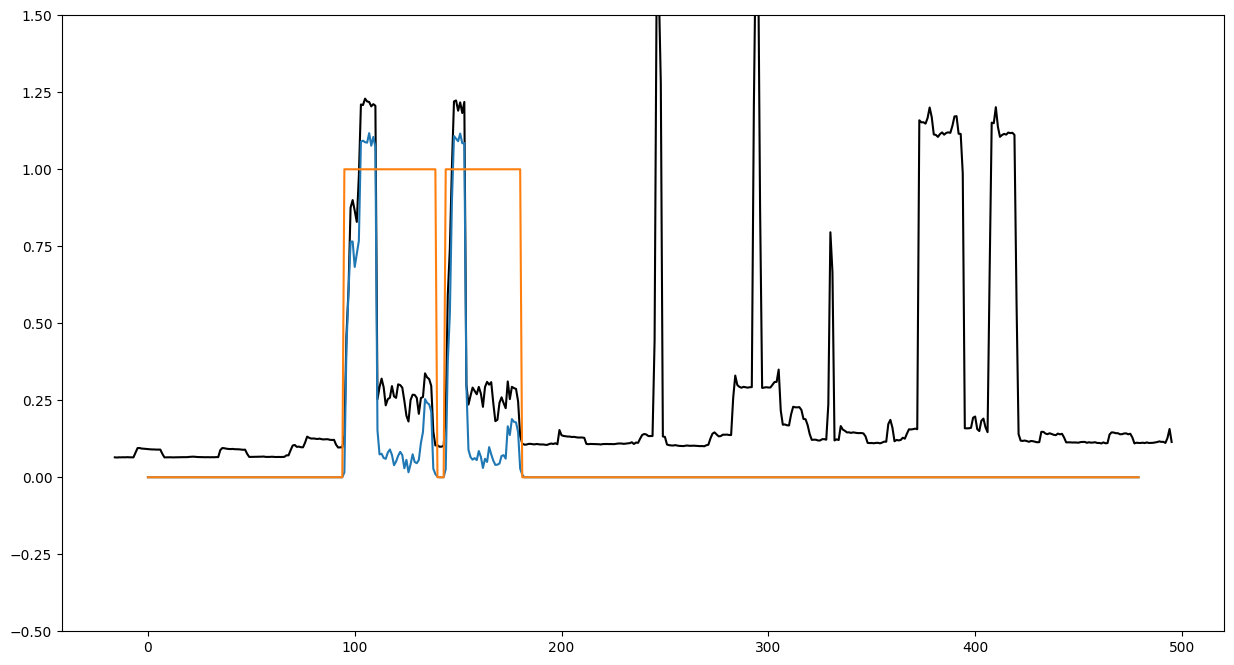

In [23]:
plt.figure(figsize=(15, 8))

# Assuming dataiter is a DataLoader object
for x, y, s in dataiter:
    if y[0, :, a].sum() > 0:
        break
    if s[0, :, a].sum() > 0:
        break

plt.plot(np.arange(-BORDER, SEQ_LEN + BORDER), x[0, :].detach().numpy(), 'k-')
plt.plot(y[0, :, a].detach().numpy())
plt.plot(s[0, :, a].detach().numpy())
plt.ylim([-0.5, 1.5])

In [24]:
model = ConvLSTMModel(1,3,32).cuda()
model.eval()

ConvLSTMModel(
  (conv1d): Conv1d(1, 32, kernel_size=(4,), stride=(1,), padding=same)
  (lstm1): LSTM(32, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=512, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=3, bias=True)
)

In [25]:
model_status = ConvLSTMModelStatus(1,3,32).cuda()
model_status.eval()

ConvLSTMModelStatus(
  (conv1d): Conv1d(1, 32, kernel_size=(4,), stride=(1,), padding=same)
  (lstm1): LSTM(32, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=512, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=3, bias=True)
)

### Loading the Trained Models for POWER Prediction in both SEEN and UNSEEN cases and testing them

**In this section, we load trained models for power prediction tasks for three target appliances. It's worth mentioning that these models were trained in other Jupyter notebook which is located in the same directory:
"powerPrediction-convLstm.ipynb" for predicting the appliance's power consumption (continuous values).**

**The purpose of loading these models is to test them on the testing sets, and plot their results in both SEEN and UNSEEN cases.**

______________
**NOTE**: The trained model has a number, representing the best-performing model out of 20 trained models using the specified architecture.
______________

In [26]:
p_hat_appliances_seen = []

thr = 0.5

start_time_seen_power_prediction = time.perf_counter()

for i in range(1):
    filename = 'UKDALE_seen_power_ConvLSTMModel_4.pth'
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, p_hat = evaluate_power(model, dl_house_test[0], a)
        p_hat_appliances_seen.append(p_hat)

end_time_seen_power_prediction = time.perf_counter()

print(f"Time taken to get power predictions 'seen': {end_time_seen_power_prediction - start_time_seen_power_prediction} seconds")

Time taken to get power predictions 'seen': 13.699691799998618 seconds


In [27]:
p_hat_appliances_unseen = []

start_time_unseen_power_prediction = time.perf_counter()

thr = 0.5
for i in range(1):
    filename = 'UKDALE_unseen_power_ConvLSTMModel_19.pth'

    model.load_state_dict(torch.load(filename))
    for  a in range(3):
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, p_hat = evaluate_power(model, dl_house_total[1], a)
        p_hat_appliances_unseen.append(p_hat)

end_time_unseen_power_prediction = time.perf_counter()

print(f"Time taken to get power predictions 'unseen': {end_time_unseen_power_prediction - start_time_unseen_power_prediction} seconds")

Time taken to get power predictions 'unseen': 29.860047099999065 seconds


### Loading the Trained Models for STATUS Prediction in both SEEN and UNSEEN cases and testing them

**Also, in this case, we are loading the trained model of status prediction which was trained in other jupyter called: "statusPrediction-convLstm.ipynb" for both SEEN and UNSEEN scenarios**

In [28]:
s_hats_seen = [[] for i in range(3)]
s_hats_unseen = [[] for i in range(3)]

**Conv-BiLSTM trained model for staus prediction for SEEN CASE**

In [29]:
thr = 0.5

start_time_seen_status_prediction = time.perf_counter()

for i in range(1):
    filename = 'UKDALE_seen_ConvLSTMModel_status_4.pth'
    model_status.load_state_dict(torch.load(filename))
    for a in range(3):
        x_true, p_true, s_true, s_hat = evaluate_activation(model_status, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        s_hats_seen[a] = copy.deepcopy(s_hat)

end_time_seen_status_prediction = time.perf_counter()

print(f"Time taken to get status predictions 'seen': {end_time_seen_status_prediction - start_time_seen_status_prediction} seconds")

Time taken to get status predictions 'seen': 13.524504500001058 seconds


**Conv-BiLSTM trained model for staus prediction for UNSEEN CASE**

In [30]:
thr = 0.5

start_time_unseen_status_prediction = time.perf_counter()

for i in range(1):
    filename = 'UKDALE_unseen_power_ConvLSTMModel_status_19.pth'
    model_status.load_state_dict(torch.load(filename))
    for a in range(3):
        x_true, p_true, s_true, s_hat = evaluate_activation(model_status, dl_house_total[1], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        s_hats_unseen[a] = copy.deepcopy(s_hat)

end_time_unseen_status_prediction = time.perf_counter()

print(f"Time taken to get status predictions 'unseen': {end_time_unseen_status_prediction - start_time_unseen_status_prediction} seconds")

Time taken to get status predictions 'unseen': 29.494602200000372 seconds


In [31]:
SEQ_LEN = 60*8
BORDER = 16
BATCH_SIZE = 32

In [32]:
# APPLIANCES = ['fridge', 'dish_washer', 'washing_machine']

mae = {}
mse = {}
rmse = {}
r_squared = {}

f1_score_s = {}
precision_s = {}
recall_s = {}
accuracy_s = {}
mcc_s = {}

In [33]:
def calculate_energy(data_normalized, y_predicted, y_actual, window):
    # aggregate, power_appliances, status_appliances = ds_house_test[house][num_window]
    
    aggregate, _, _ = data_normalized[window] # 1 number of window
    total_predicted_power = sum(y_predicted)
    total_actual_power = sum(y_actual)

    predict_percentage = total_predicted_power / sum(aggregate)
    actual_percentage = total_actual_power / sum(aggregate)

    temp = copy.deepcopy(data_normalized)
    temp.denormalize()
    
    aggregate, _, _ = temp[window]
    
    actual_consumed = actual_percentage * sum(aggregate) / 1000
    predicted_consumed = predict_percentage * sum(aggregate) / 1000

    return sum(aggregate) / 1000, actual_consumed, predicted_consumed


def r_squared_(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean)**2)
    ss_res = np.sum((y_true - y_pred)**2)

    epsilon = 1e-10
    if ss_tot == 0:
        ss_tot = epsilon
    
    return 1 - (ss_res / ss_tot)

In [34]:
def apply_test(ds, p_hat, appliance=0, break_when=0, type='seen'):
    app = ""
    
    dataiter = iter(ds)

    cnt = 0

    break_index = None
    for idx, (x, y, s) in enumerate(dataiter):
        if y[0, :, appliance].sum() > 0 and cnt >= break_when:
            y_actual = y.permute(0,2,1)[:,appliance,:][0].contiguous().view(-1).detach().cpu().numpy()
            break_index = idx
            break
        cnt += 1
        
    print("Break index:", break_index)

    # p_hat[doesn't matter][break_index][idk][APPLIANCE]
    y_predicted = p_hat[0][break_index][0][appliance].contiguous().view(-1).detach().cpu().numpy()

    if appliance == 0:
        mae['fridge'] = mean_absolute_error(y_actual, y_predicted)
        mse['fridge'] = mean_squared_error(y_actual, y_predicted)
        rmse['fridge'] = np.sqrt(mse['fridge'])
        r_squared['fridge'] = r_squared_(y_actual, y_predicted)
        app = "Fridge"
    elif appliance == 1:
        mae['dish_washer'] = mean_absolute_error(y_actual, y_predicted)
        mse['dish_washer'] = mean_squared_error(y_actual, y_predicted)
        rmse['dish_washer'] = np.sqrt(mse['dish_washer'])
        r_squared['dish_washer'] = r_squared_(y_actual, y_predicted)
        app = "Dish Washer"
    elif appliance == 2:
        mae['washing_machine'] = mean_absolute_error(y_actual, y_predicted)
        mse['washing_machine'] = mean_squared_error(y_actual, y_predicted)
        rmse['washing_machine'] = np.sqrt(mse['washing_machine'])
        r_squared['washing_machine'] = r_squared_(y_actual, y_predicted)
        app = "Washing Machine"

    # Calculate the error
    error = y_predicted - y_actual

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(-BORDER, SEQ_LEN + BORDER), x.contiguous().view(-1).detach().cpu().numpy(), label='Aggregate Power')
    plt.plot(y_actual, label='Actual')
    plt.plot(y_predicted, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Actual Power vs Predicted Power [{app} {type}]')
    plt.legend()
    plt.show()
    
    total_aggregate_energy, actual_consumed_energy, predicted_consumed_energy = calculate_energy(ds_house_test[0], y_predicted, y_actual, break_index)

    print(f"Total Aggregate Energy is {total_aggregate_energy:.2f}kw/8h\n"
      f"Actual Energy Consumed by the {app} is {actual_consumed_energy:.2f}kw/8h\n"
      f"Predicted Energy Consumed by the {app} is {predicted_consumed_energy:.2f}kw/8h")

In [35]:
def apply_test_status(dl, s_hats, appliance=0, type='seen', break_at=0):
    app = ""

    dataiter = iter(dl)

    plt.figure(figsize=(15, 8))

    cnt = 0

    break_index = None
    for idx, (x, y, s) in enumerate(dataiter):
        if y[0, :, appliance].sum() > 0 and cnt >= break_at:
            break_index = idx
            break
        if s[0, :, appliance].sum() > 0 and cnt >= break_at:
            break_index = idx
            break
        cnt += 1
        
    print("Break index:", break_index)

    # Assuming s_hat is the nparray you want to plot
    start_index = break_index * 480
    end_index = start_index + 480

    if appliance == 0:
        f1_score_s['fridge'] = f1_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        precision_s['fridge'] = precision_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        recall_s['fridge'] = recall_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        accuracy_s['fridge'] = accuracy_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        mcc_s['fridge'] = matthews_corrcoef(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        app = "Fridge"
    elif appliance == 1:
        f1_score_s['dish_washer'] = f1_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        precision_s['dish_washer'] = precision_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        recall_s['dish_washer'] = recall_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        accuracy_s['dish_washer'] = accuracy_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        mcc_s['dish_washer'] = matthews_corrcoef(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        app = "Dish Washer"
    elif appliance == 2:
        f1_score_s['washing_machine'] = f1_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        precision_s['washing_machine'] = precision_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        recall_s['washing_machine'] = recall_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        accuracy_s['washing_machine'] = accuracy_score(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        mcc_s['washing_machine'] = matthews_corrcoef(s[0, :, appliance].detach().numpy(), s_hats[appliance][start_index:end_index])
        app = "Washing Machine"

    plt.plot(np.arange(-BORDER, SEQ_LEN + BORDER), x[0, :].detach().numpy(), 'k-', label='Aggregate')
    plt.plot(s[0, :, appliance].detach().numpy(), label='Actual Status')
    plt.plot(np.arange(start_index - start_index, end_index - start_index), s_hats[appliance][start_index:end_index], 'r-', label='Predicted Status')

    plt.title(f'Actual Status vs Predicted Status [{app} {type}]')
    plt.xlabel('Window Size')
    plt.ylabel('Status')

    plt.ylim([-0.5, 1.5])

    plt.legend()
    plt.grid(True)
    plt.show()

### Plotting the results for both models (POWER and STATUS prediction) - SEEN CASE

#### ***Fridge - SEEN CASE***

Break index: 0


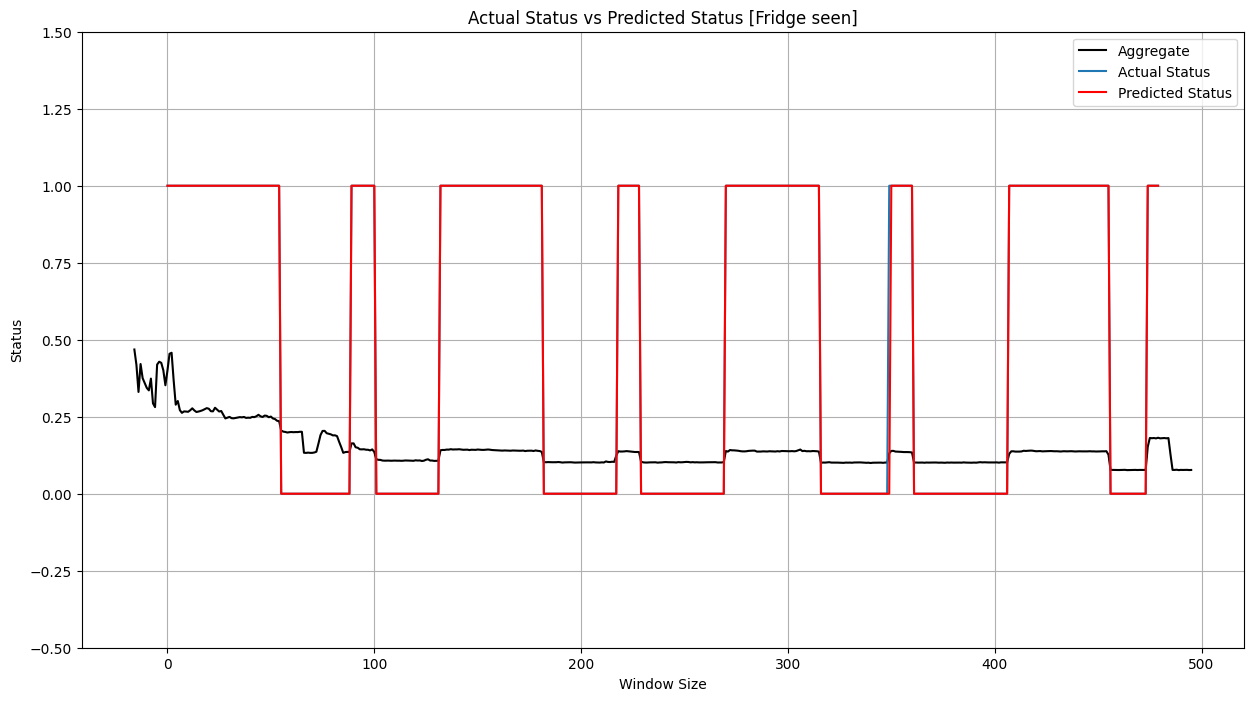

In [36]:
apply_test_status(dl_house_test[0], s_hats_seen, 0, 'seen')

Break index: 0


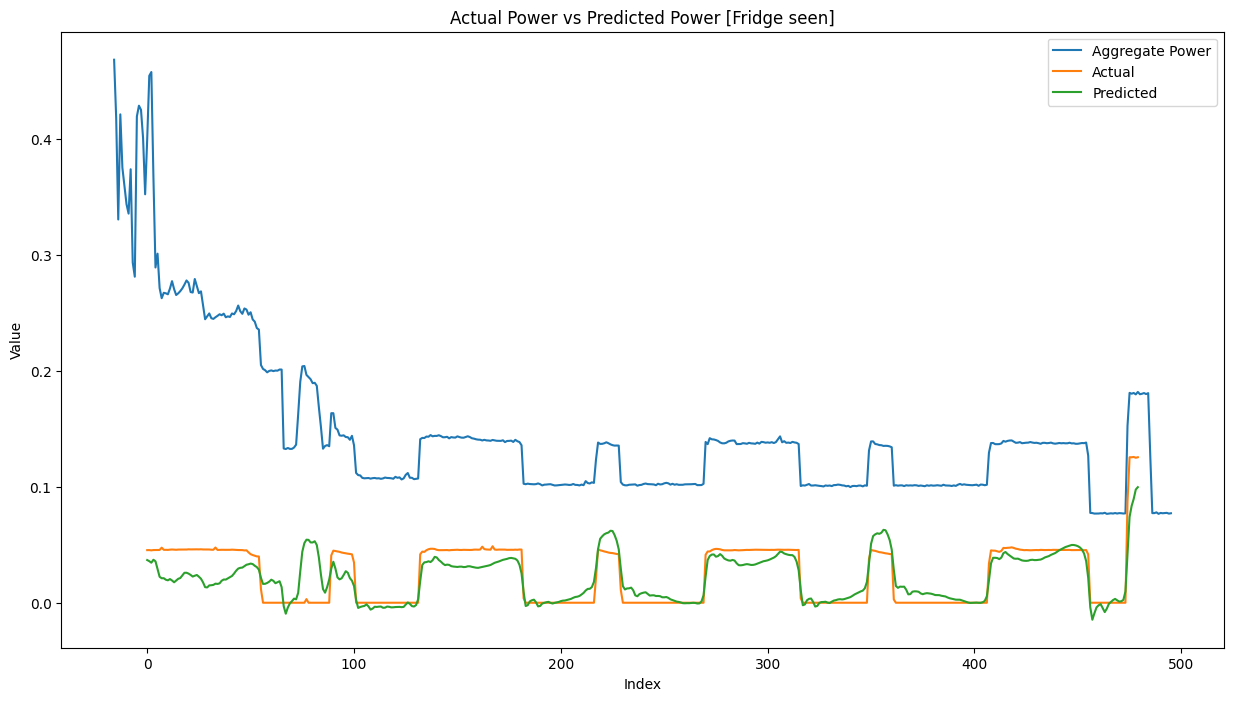

Total Aggregate Energy is 150.71kw/8h
Actual Energy Consumed by the Fridge is 22.72kw/8h
Predicted Energy Consumed by the Fridge is 20.30kw/8h


In [37]:
apply_test(dl_house_test[0], p_hat_appliances_seen)

#### ***Dish Washer - SEEN CASE***

Break index: 3


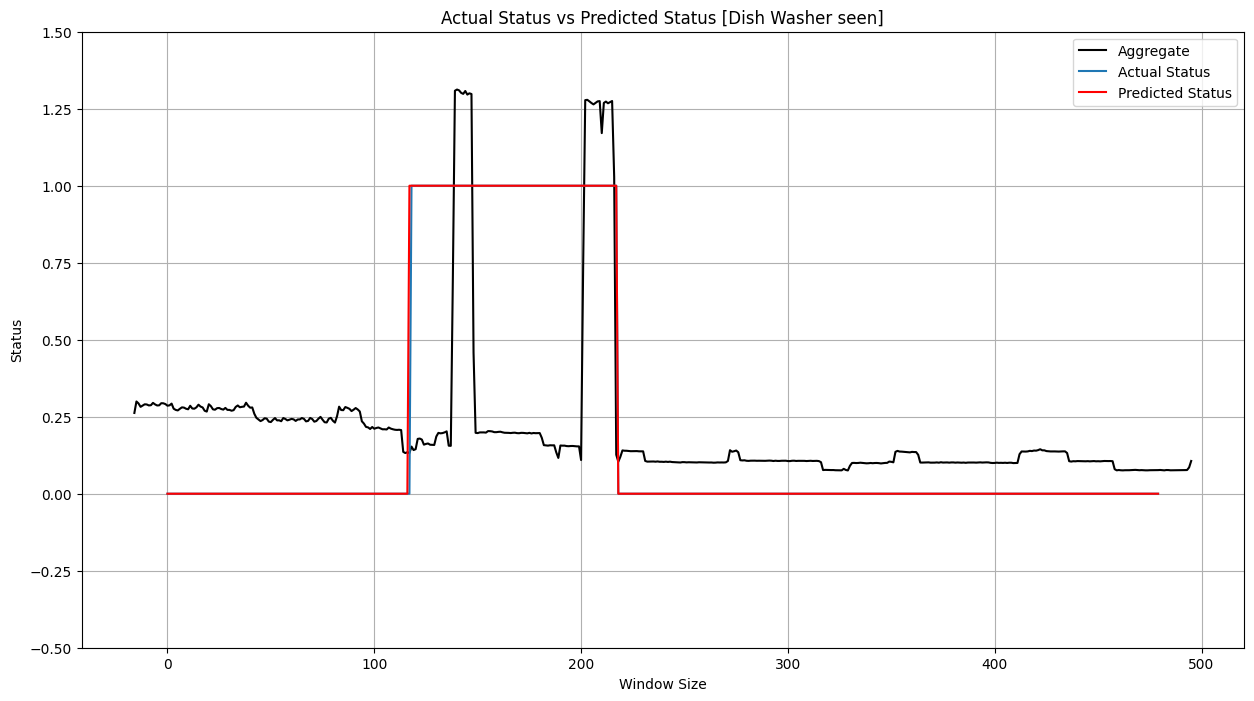

In [38]:
apply_test_status(dl_house_test[0], s_hats_seen, 1, 'seen')

Break index: 3


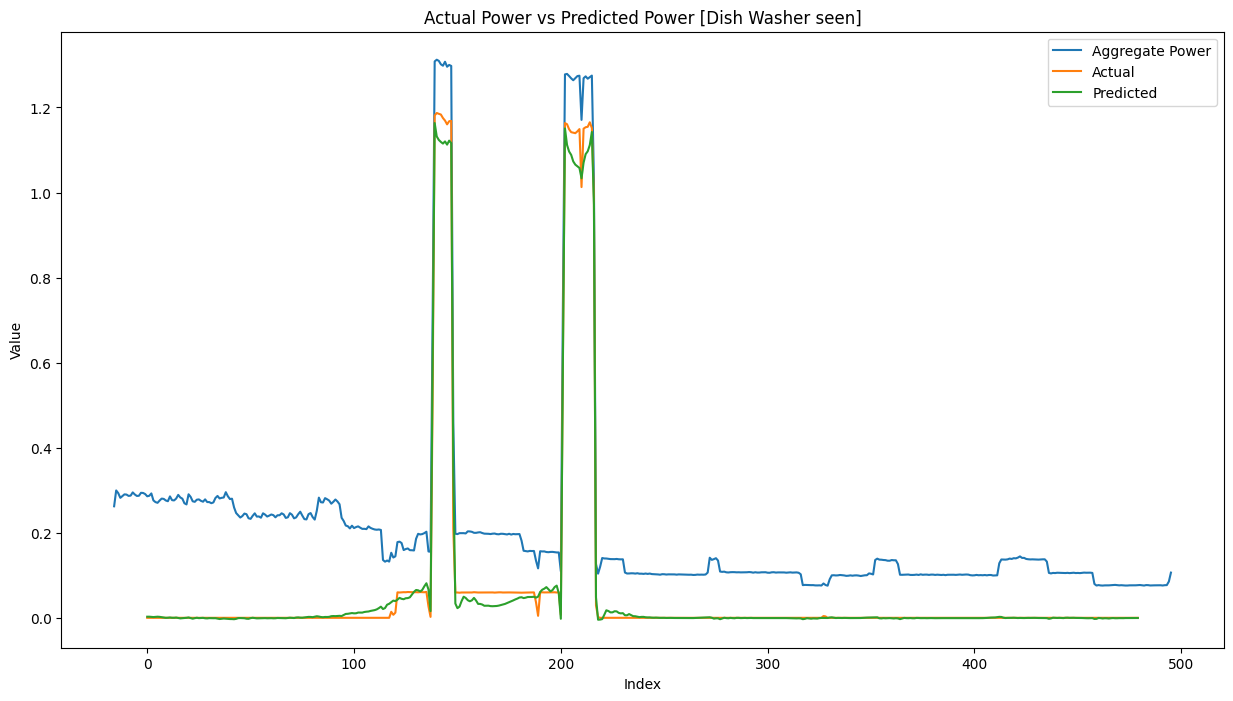

Total Aggregate Energy is 216.96kw/8h
Actual Energy Consumed by the Dish Washer is 65.71kw/8h
Predicted Energy Consumed by the Dish Washer is 63.29kw/8h


In [39]:
apply_test(dl_house_test[0], p_hat_appliances_seen, 1)

#### ***Washing Machine - SEEN CASE***

Break index: 1


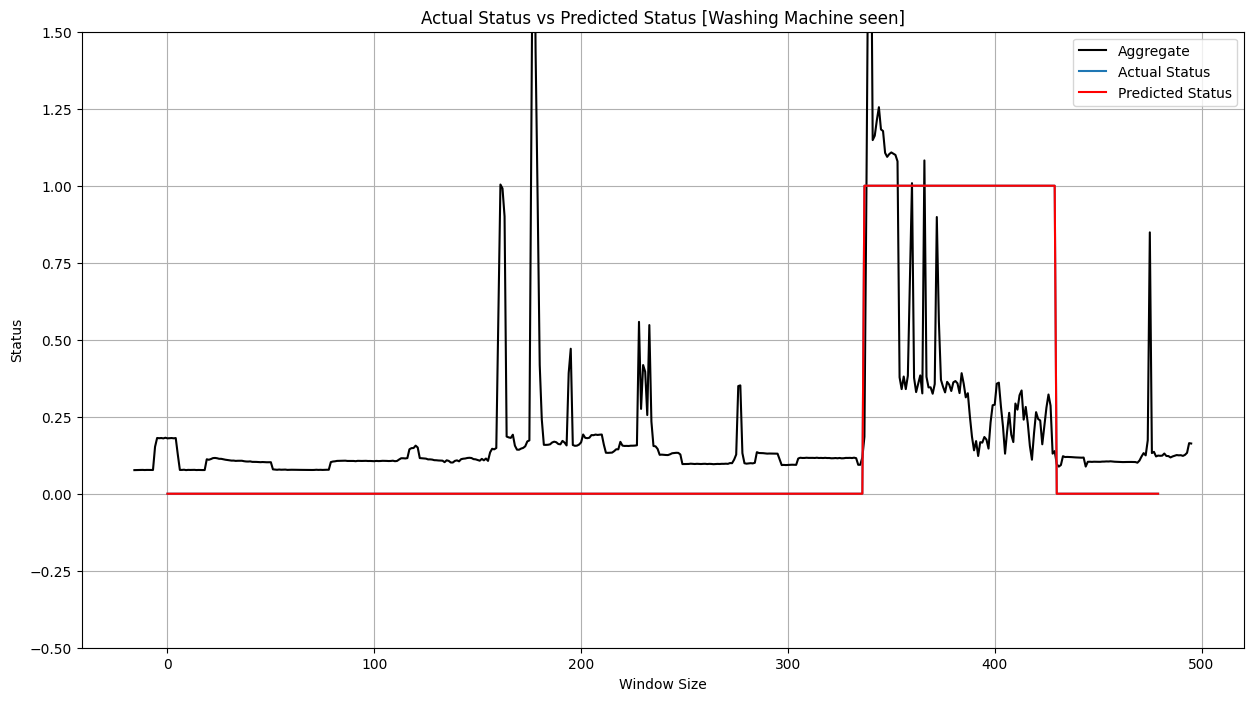

In [40]:
apply_test_status(dl_house_test[0], s_hats_seen, 2, 'seen', 1)

Break index: 1


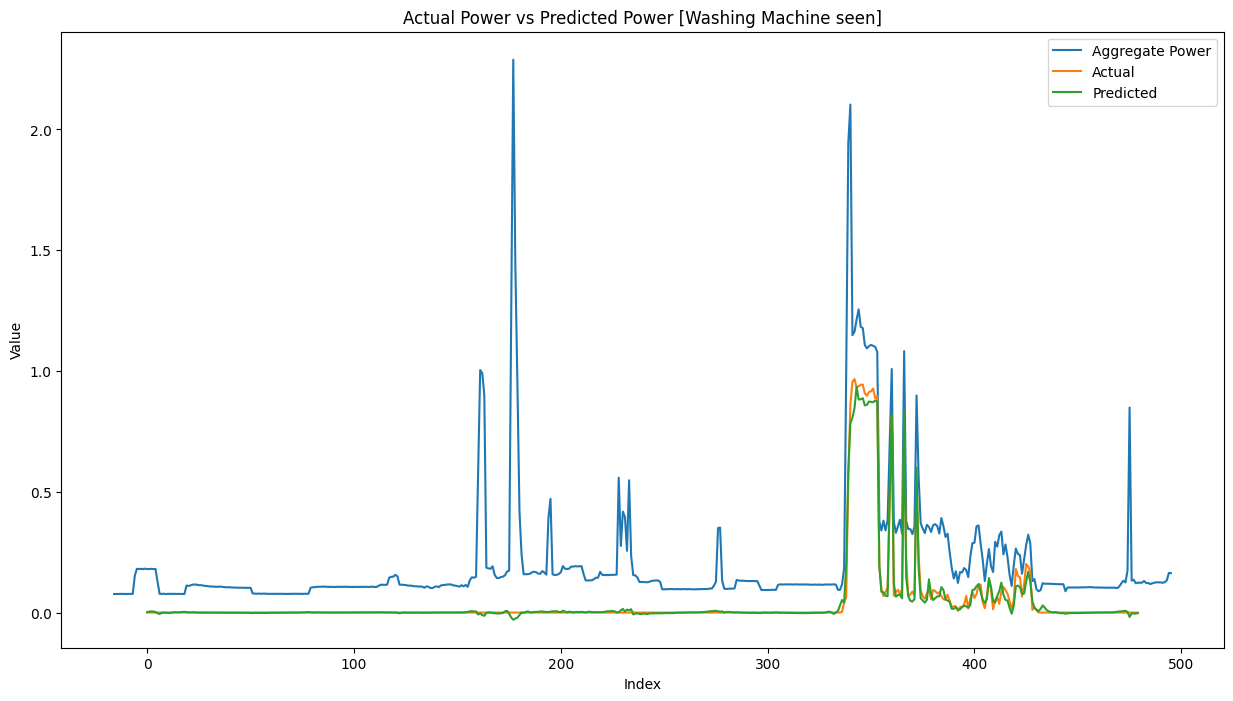

Total Aggregate Energy is 211.14kw/8h
Actual Energy Consumed by the Washing Machine is 43.91kw/8h
Predicted Energy Consumed by the Washing Machine is 41.83kw/8h


In [41]:
apply_test(dl_house_test[0], p_hat_appliances_seen, 2, 1)

### The Evaluation Metrics of Power Prediction - SEEN CASE

In [42]:
print(f"fridge\nMAE  :{mae['fridge']}\nMSE  :{mse['fridge']}\nRMSE  :{rmse['fridge']}\nR Squared  :{r_squared['fridge']}")
print(f"\ndish_washer\nMAE  :{mae['dish_washer']}\nMSE  :{mse['dish_washer']}\nRMSE  :{rmse['dish_washer']}\nR Squared  :{r_squared['dish_washer']}")
print(f"\nwashing_machine\nMAE  :{mae['washing_machine']}\nMSE  :{mse['washing_machine']}\nRMSE  :{rmse['washing_machine']}\nR Squared  :{r_squared['washing_machine']}")

fridge
MAE  :0.010319781489670277
MSE  :0.00020061327086295933
RMSE  :0.014163801446557045
R Squared  :0.6744954884052277

dish_washer
MAE  :0.007627866696566343
MSE  :0.0002957485557999462
RMSE  :0.017197340726852417
R Squared  :0.9953191094100475

washing_machine
MAE  :0.008096328005194664
MSE  :0.00035123564884997904
RMSE  :0.01874128170311451
R Squared  :0.9875781647861004


### The Evaluation Metrics of STATUS Prediction - SEEN CASE

In [43]:
print(f"fridge\nF1 Score  :{f1_score_s['fridge']}\nPrecision  :{precision_s['fridge']}\nRecall  :{recall_s['fridge']}\nAccuracy  :{accuracy_s['fridge']}\nMCC  :{mcc_s['fridge']}")
print(f"\ndish_washer\nF1 Score  :{f1_score_s['dish_washer']}\nPrecision  :{precision_s['dish_washer']}\nRecall  :{recall_s['dish_washer']}\nAccuracy  :{accuracy_s['dish_washer']}\nMCC  :{mcc_s['dish_washer']}")
print(f"\nwashing_machine\nF1 Score  :{f1_score_s['washing_machine']}\nPrecision  :{precision_s['washing_machine']}\nRecall  :{recall_s['washing_machine']}\nAccuracy  :{accuracy_s['washing_machine']}\nMCC  :{mcc_s['washing_machine']}")

fridge
F1 Score  :0.997920997920998
Precision  :1.0
Recall  :0.995850622406639
Accuracy  :0.9979166666666667
MCC  :0.9958419778324661

dish_washer
F1 Score  :0.9950248756218906
Precision  :0.9900990099009901
Recall  :1.0
Accuracy  :0.9979166666666667
MCC  :0.9937270682590489

washing_machine
F1 Score  :1.0
Precision  :1.0
Recall  :1.0
Accuracy  :1.0
MCC  :1.0


### Different Prediction Window for both STATUS and POWER prediction with Evaluation Metrices

In [44]:
mae = {}
mse = {}
rmse = {}
r_squared = {}

f1_score_s = {}
precision_s = {}
recall_s = {}
accuracy_s = {}
mcc_s = {}

#### ***Fridge - SEEN CASE***

Break index: 6


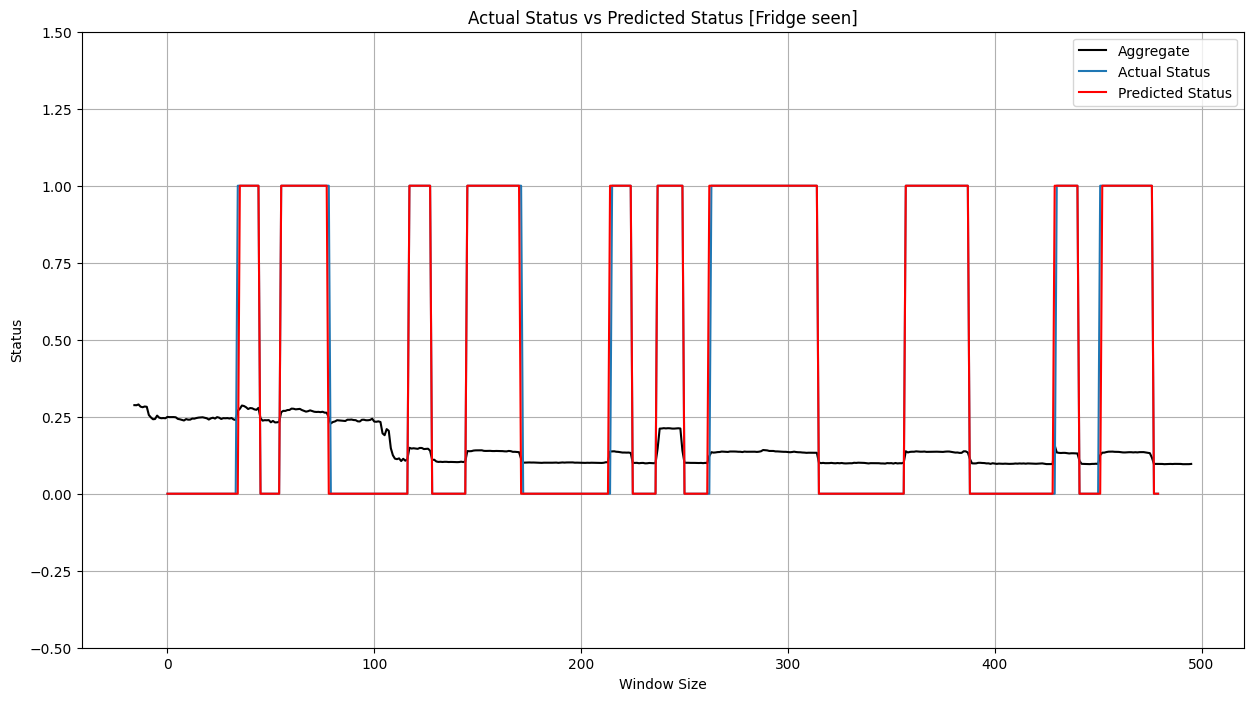

In [45]:
apply_test_status(dl_house_test[0], s_hats_seen, 0, 'seen', 6)

Break index: 6


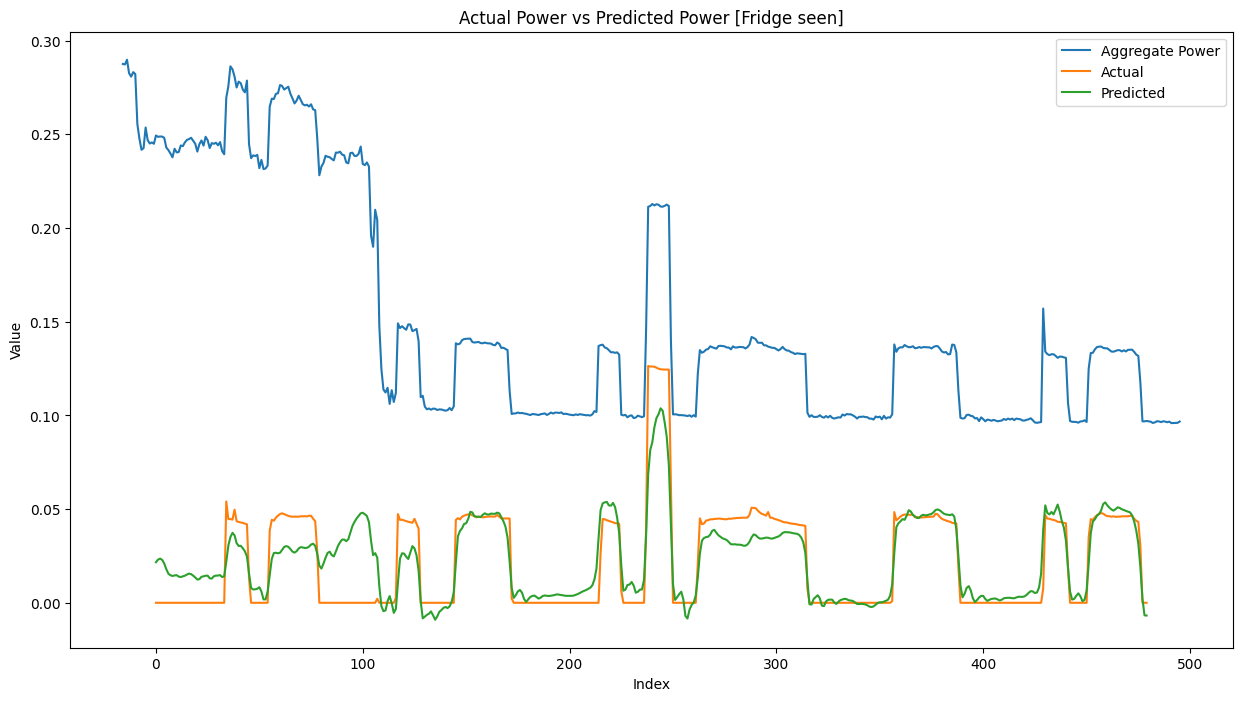

Total Aggregate Energy is 155.00kw/8h
Actual Energy Consumed by the Fridge is 21.36kw/8h
Predicted Energy Consumed by the Fridge is 22.10kw/8h


In [46]:
apply_test(dl_house_test[0], p_hat_appliances_seen, 0, 6)

#### ***Dish Washer - SEEN CASE***

Break index: 12


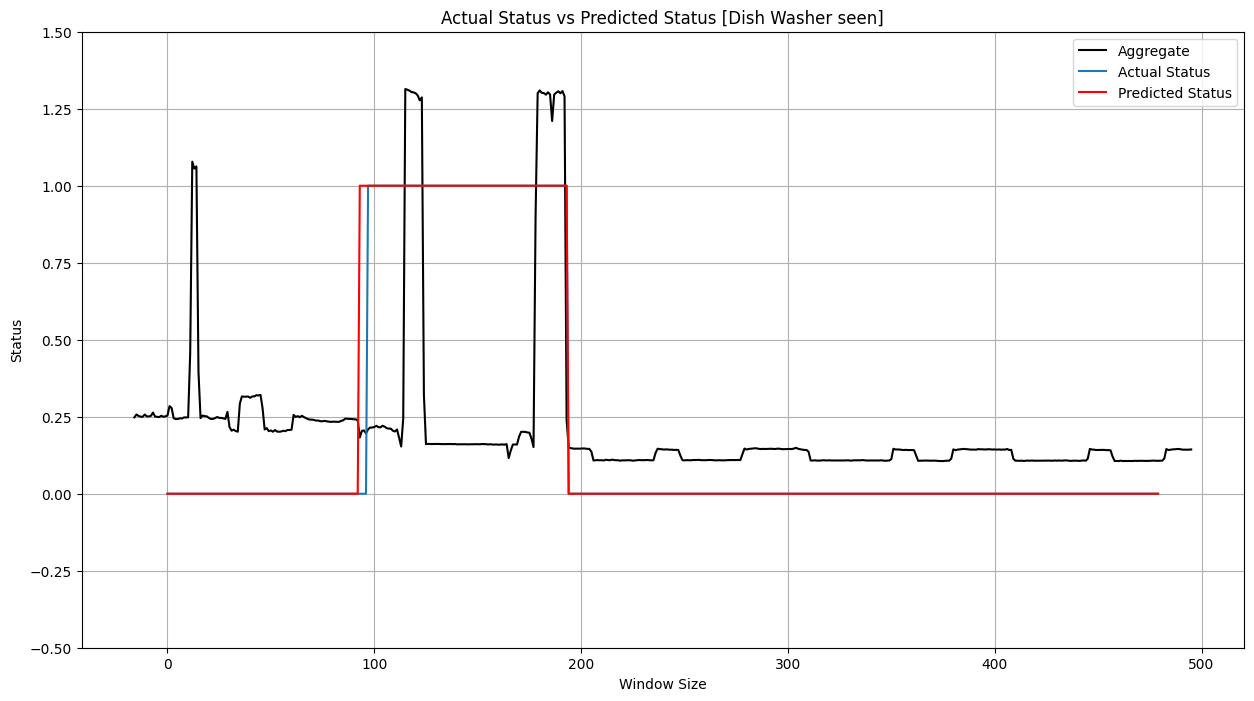

In [47]:
apply_test_status(dl_house_test[0], s_hats_seen, 1, 'seen', 10)

Break index: 12


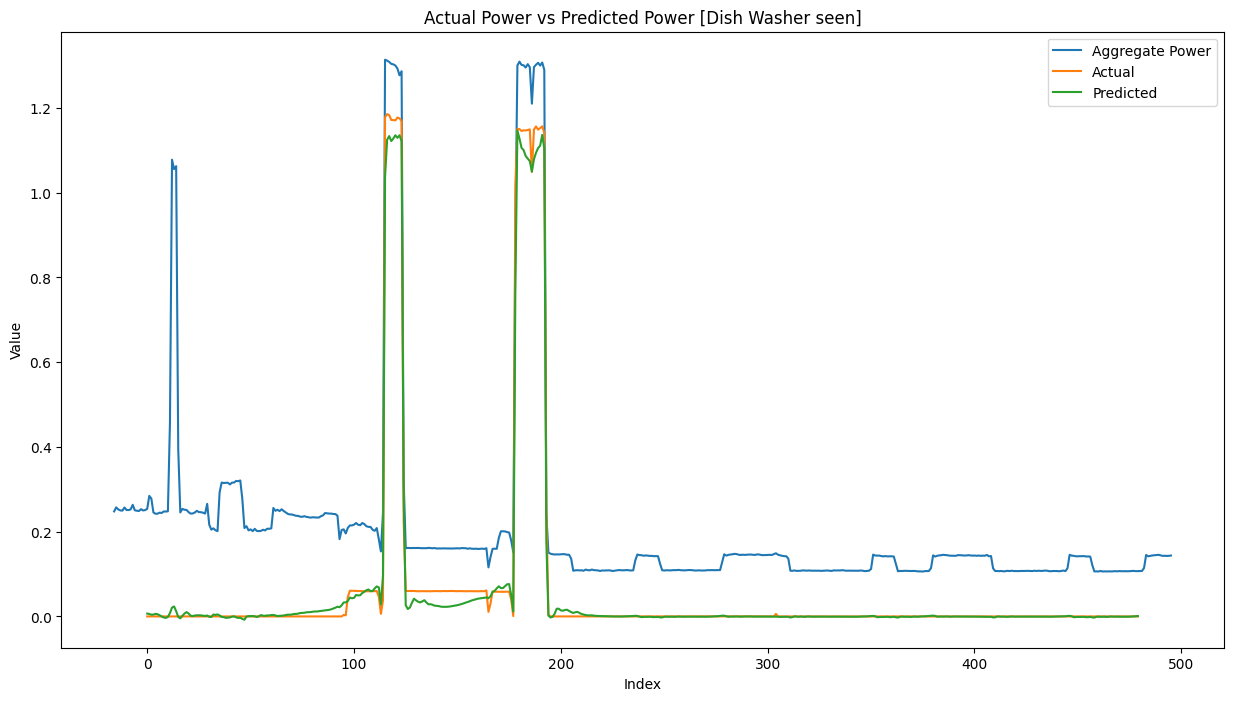

Total Aggregate Energy is 222.44kw/8h
Actual Energy Consumed by the Dish Washer is 64.13kw/8h
Predicted Energy Consumed by the Dish Washer is 60.64kw/8h


In [48]:
apply_test(dl_house_test[0], p_hat_appliances_seen, 1, 10)

#### ***Washing Machine - SEEN CASE***

Break index: 11


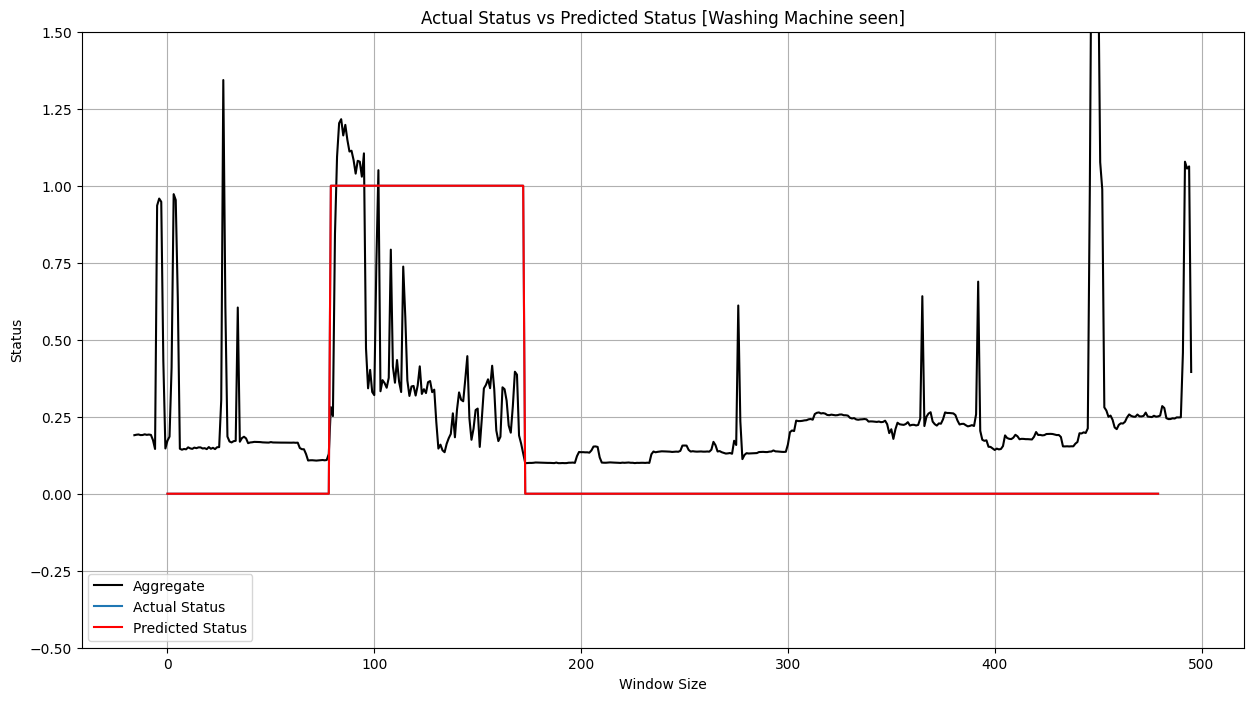

In [49]:
apply_test_status(dl_house_test[0], s_hats_seen, 2, 'seen', 10)

Break index: 11


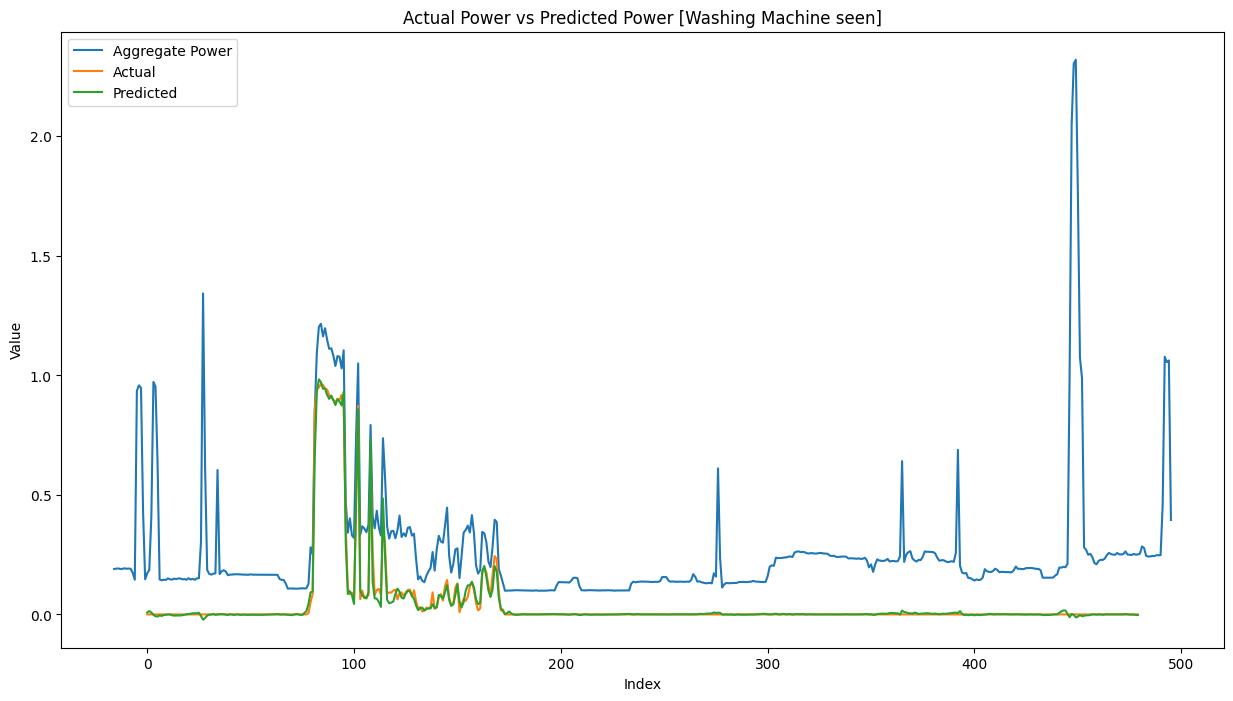

Total Aggregate Energy is 276.04kw/8h
Actual Energy Consumed by the Washing Machine is 45.98kw/8h
Predicted Energy Consumed by the Washing Machine is 45.00kw/8h


In [50]:
apply_test(dl_house_test[0], p_hat_appliances_seen, 2, 10)

#### ***The Evaluation Metrics of POWER Prediction***

In [51]:
print(f"fridge\nMAE  :{mae['fridge']}\nMSE  :{mse['fridge']}\nRMSE  :{rmse['fridge']}\nR Squared  :{r_squared['fridge']}")
print(f"\ndish_washer\nMAE  :{mae['dish_washer']}\nMSE  :{mse['dish_washer']}\nRMSE  :{rmse['dish_washer']}\nR Squared  :{r_squared['dish_washer']}")
print(f"\nwashing_machine\nMAE  :{mae['washing_machine']}\nMSE  :{mse['washing_machine']}\nRMSE  :{rmse['washing_machine']}\nR Squared  :{r_squared['washing_machine']}")

fridge
MAE  :0.009521117433905602
MSE  :0.00019008821982424706
RMSE  :0.01378724817186594
R Squared  :0.7403504848480225

dish_washer
MAE  :0.00840153731405735
MSE  :0.00041015769238583744
RMSE  :0.020252350717782974
R Squared  :0.9934292808175087

washing_machine
MAE  :0.00663255387917161
MSE  :0.0003063031181227416
RMSE  :0.01750151813030243
R Squared  :0.9894994050264359


#### ***The Evaluation Metrics of STATUS Prediction***

In [52]:
print(f"fridge\nF1 Score  :{f1_score_s['fridge']}\nPrecision  :{precision_s['fridge']}\nRecall  :{recall_s['fridge']}\nAccuracy  :{accuracy_s['fridge']}\nMCC  :{mcc_s['fridge']}")
print(f"\ndish_washer\nF1 Score  :{f1_score_s['dish_washer']}\nPrecision  :{precision_s['dish_washer']}\nRecall  :{recall_s['dish_washer']}\nAccuracy  :{accuracy_s['dish_washer']}\nMCC  :{mcc_s['dish_washer']}")
print(f"\nwashing_machine\nF1 Score  :{f1_score_s['washing_machine']}\nPrecision  :{precision_s['washing_machine']}\nRecall  :{recall_s['washing_machine']}\nAccuracy  :{accuracy_s['washing_machine']}\nMCC  :{mcc_s['washing_machine']}")

fridge
F1 Score  :0.9837587006960558
Precision  :0.986046511627907
Recall  :0.9814814814814815
Accuracy  :0.9854166666666667
MCC  :0.9705349189072177

dish_washer
F1 Score  :0.9797979797979798
Precision  :0.9603960396039604
Recall  :1.0
Accuracy  :0.9916666666666667
MCC  :0.9748670646603733

washing_machine
F1 Score  :1.0
Precision  :1.0
Recall  :1.0
Accuracy  :1.0
MCC  :1.0


### Plotting the results for both models (POWER and STATUS prediction) - UNSEEN CASE

In [53]:
mae = {}
mse = {}
rmse = {}
r_squared = {}

f1_score_s = {}
precision_s = {}
recall_s = {}
accuracy_s = {}
mcc_s = {}

#### 0 Fridge, 1 Dish Washer, 2 Washing Machine

#### ***Fridge - UNSEEN CASE***

Break index: 1


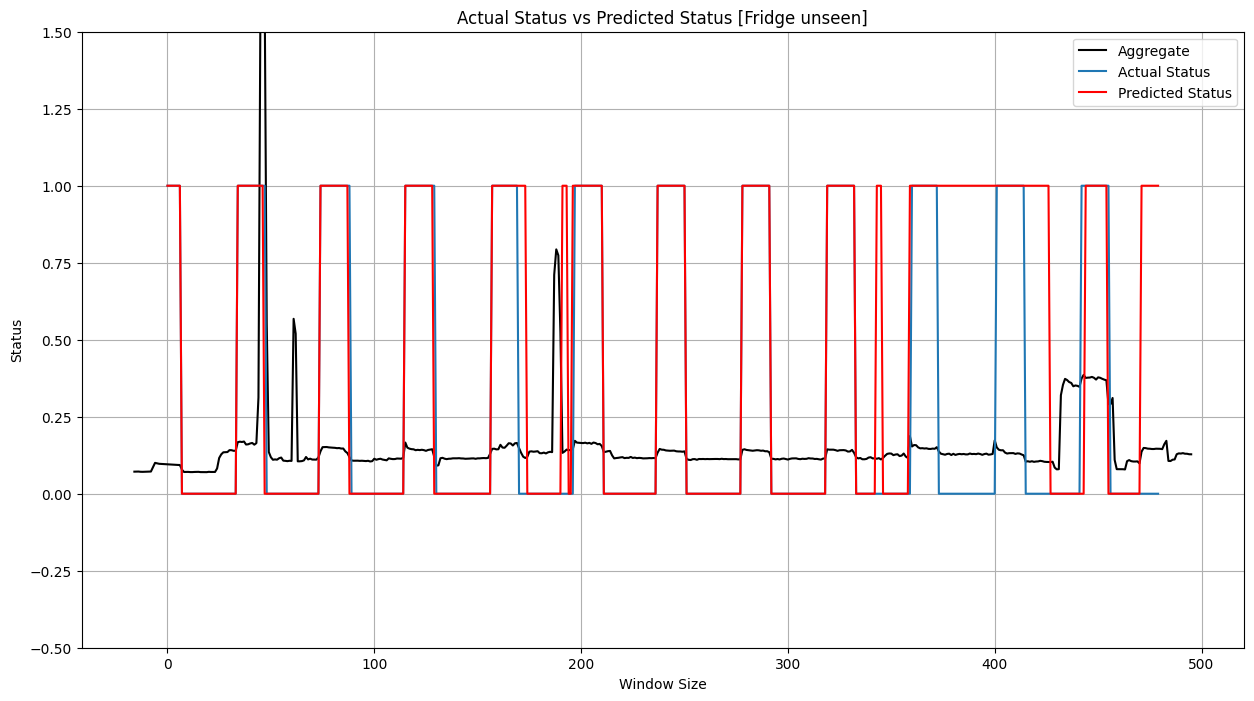

In [54]:
apply_test_status(dl_house_total[1], s_hats_unseen, 0, 'unseen', 1)

Break index: 1


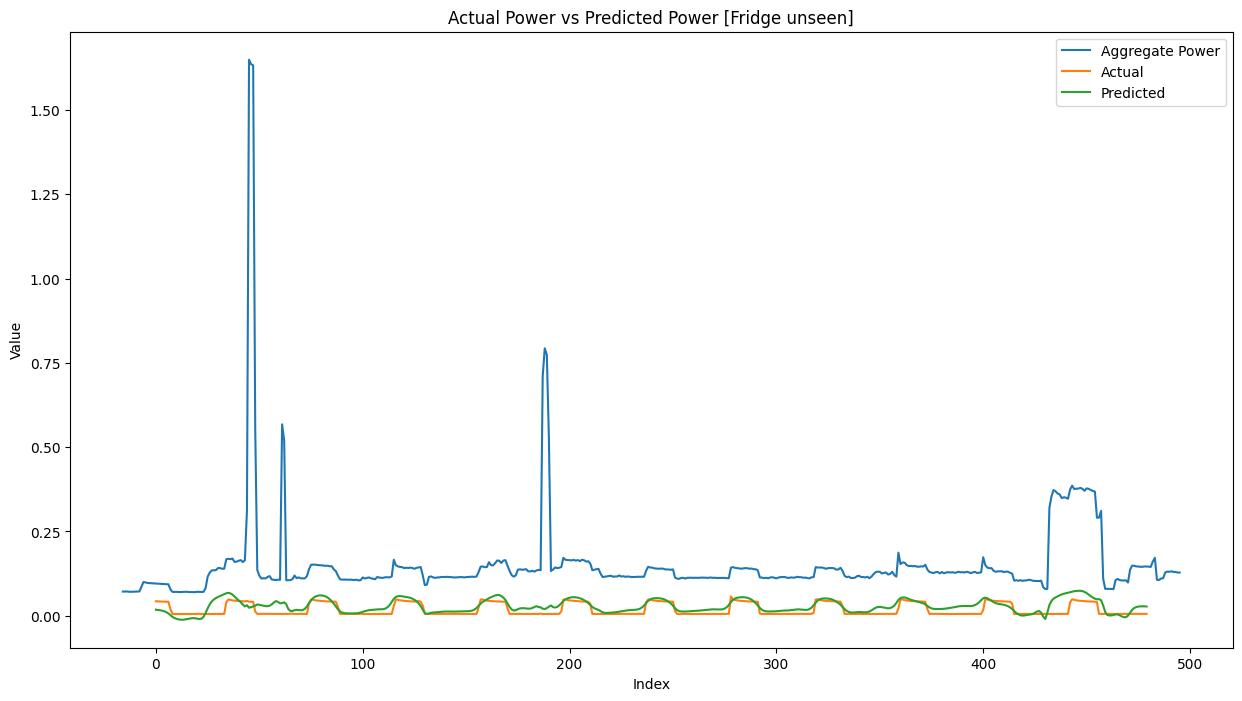

Total Aggregate Energy is 211.14kw/8h
Actual Energy Consumed by the Fridge is 17.62kw/8h
Predicted Energy Consumed by the Fridge is 27.07kw/8h


In [55]:
apply_test(dl_house_total[1], p_hat_appliances_unseen, 0, 1, 'unseen')

#### ***Dish Washer - UNSEEN CASE***

Break index: 5


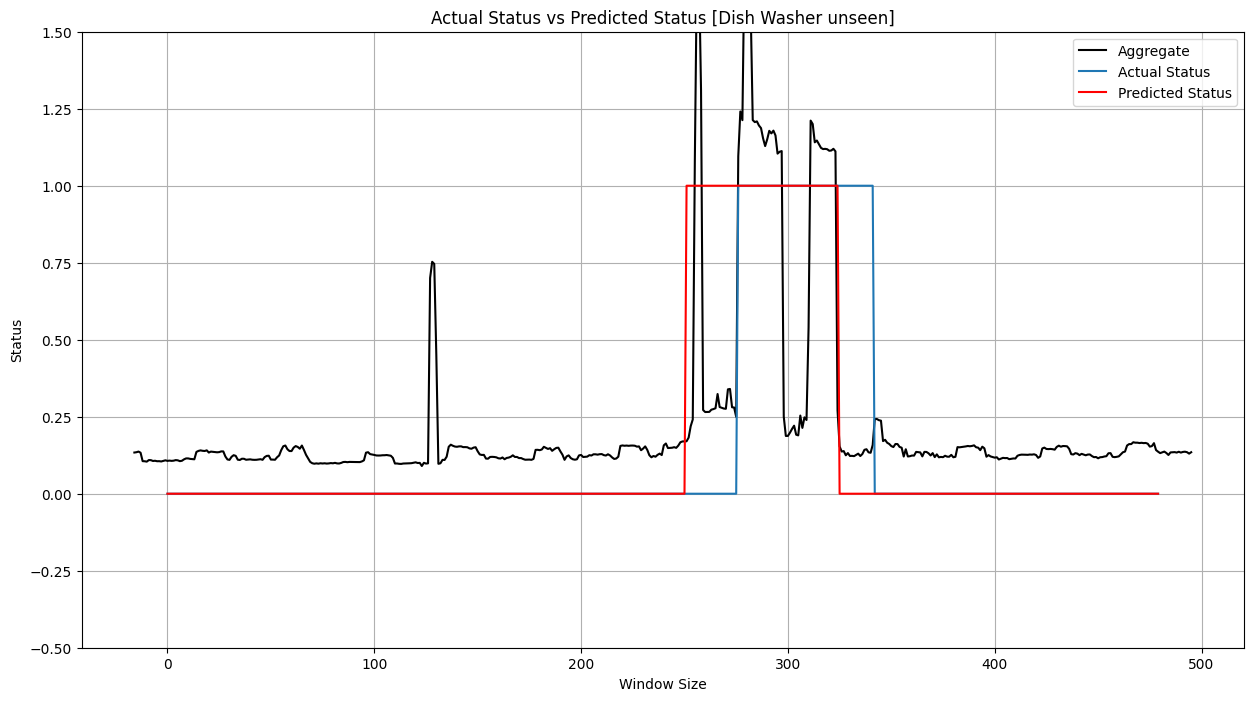

In [56]:
apply_test_status(dl_house_total[1], s_hats_unseen, 1, 'unseen', 3)

Break index: 5


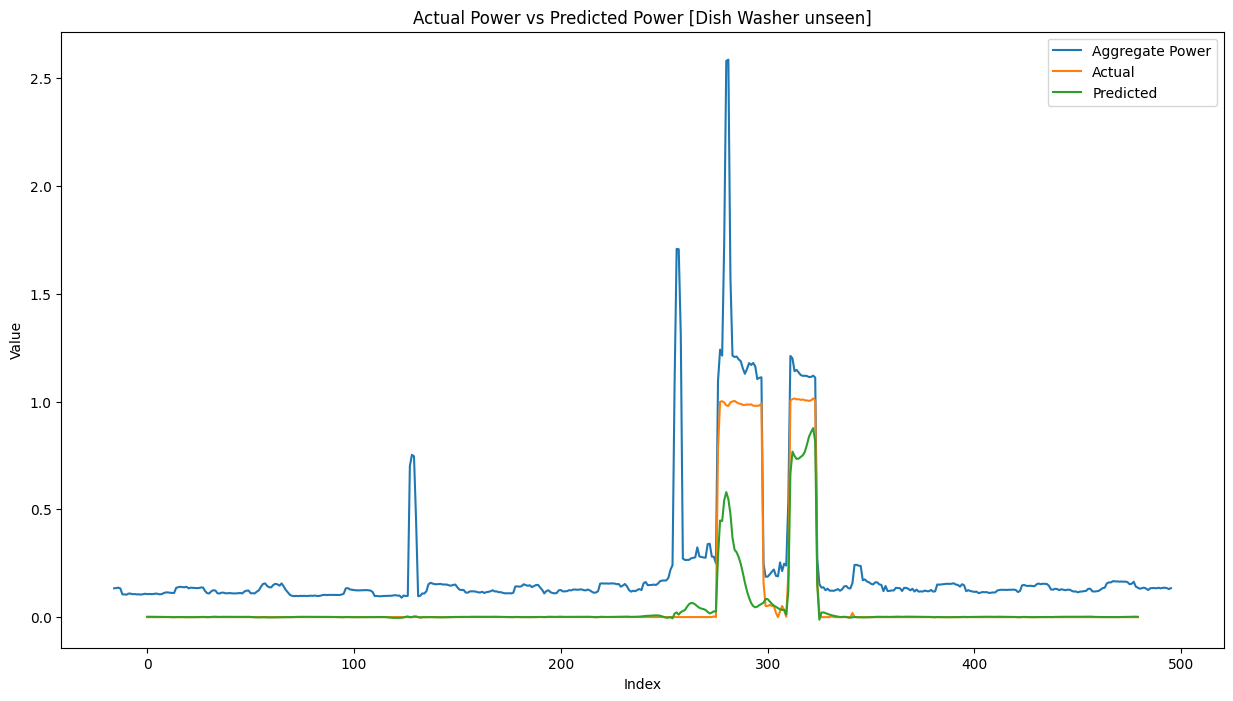

Total Aggregate Energy is 226.87kw/8h
Actual Energy Consumed by the Dish Washer is 71.28kw/8h
Predicted Energy Consumed by the Dish Washer is 35.88kw/8h


In [57]:
apply_test(dl_house_total[1], p_hat_appliances_unseen, 1, 3, 'unseen')

#### ***Washing Machine - UNSEEN CASE***

Break index: 13


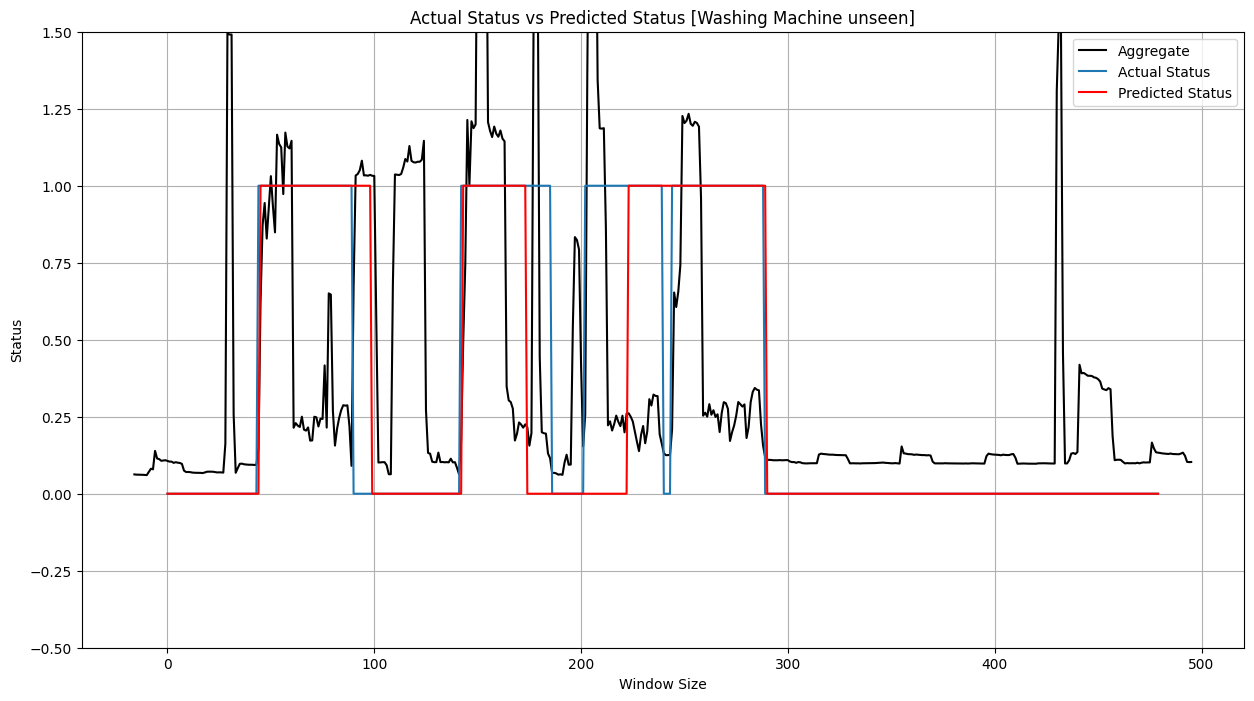

In [58]:
apply_test_status(dl_house_total[1], s_hats_unseen, 2, 'unseen', 3)

Break index: 13


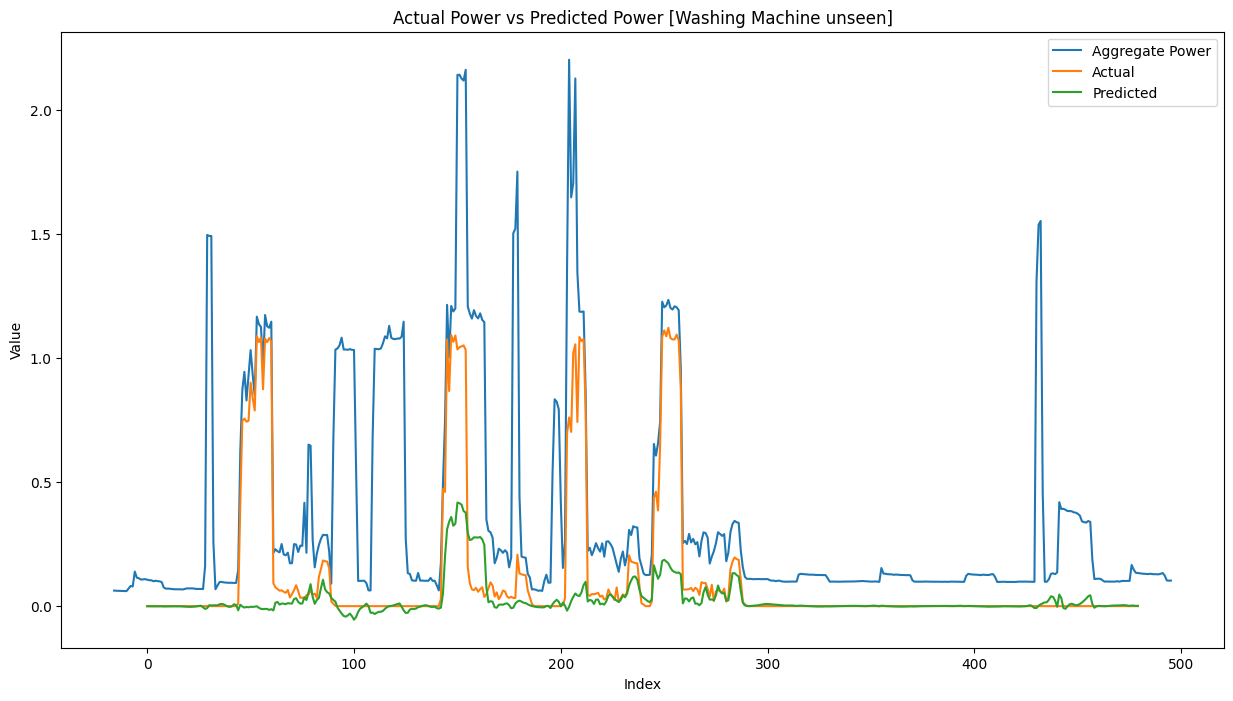

Total Aggregate Energy is 185.86kw/8h
Actual Energy Consumed by the Washing Machine is 112.36kw/8h
Predicted Energy Consumed by the Washing Machine is 25.13kw/8h


In [59]:
apply_test(dl_house_total[1], p_hat_appliances_unseen, 2, 3, 'unseen')

### The Evaluation Metrics of Power Prediction - UNSEEN CASE

In [60]:
print(f"fridge\nMAE  :{mae['fridge']}\nMSE  :{mse['fridge']}\nRMSE  :{rmse['fridge']}\nR Squared  :{r_squared['fridge']}")
print(f"\ndish_washer\nMAE  :{mae['dish_washer']}\nMSE  :{mse['dish_washer']}\nRMSE  :{rmse['dish_washer']}\nR Squared  :{r_squared['dish_washer']}")
print(f"\nwashing_machine\nMAE  :{mae['washing_machine']}\nMSE  :{mse['washing_machine']}\nRMSE  :{rmse['washing_machine']}\nR Squared  :{r_squared['washing_machine']}")

fridge
MAE  :0.01370958425104618
MSE  :0.0003060997696593404
RMSE  :0.01749570667743683
R Squared  :0.05355411767959595

dish_washer
MAE  :0.04296044632792473
MSE  :0.02690143510699272
RMSE  :0.16401657462120056
R Squared  :0.5946146249771118

washing_machine
MAE  :0.10277135670185089
MSE  :0.07412384450435638
RMSE  :0.2722569406032562
R Squared  :0.10540097951889038


### The Evaluation Metrics of STATUS Prediction - UNSEEN CASE

In [61]:
print(f"fridge\nF1 Score  :{f1_score_s['fridge']}\nPrecision  :{precision_s['fridge']}\nRecall  :{recall_s['fridge']}\nAccuracy  :{accuracy_s['fridge']}\nMCC  :{mcc_s['fridge']}")
print(f"\ndish_washer\nF1 Score  :{f1_score_s['dish_washer']}\nPrecision  :{precision_s['dish_washer']}\nRecall  :{recall_s['dish_washer']}\nAccuracy  :{accuracy_s['dish_washer']}\nMCC  :{mcc_s['dish_washer']}")
print(f"\nwashing_machine\nF1 Score  :{f1_score_s['washing_machine']}\nPrecision  :{precision_s['washing_machine']}\nRecall  :{recall_s['washing_machine']}\nAccuracy  :{accuracy_s['washing_machine']}\nMCC  :{mcc_s['washing_machine']}")

fridge
F1 Score  :0.8222811671087532
Precision  :0.7175925925925926
Recall  :0.9627329192546584
Accuracy  :0.8604166666666667
MCC  :0.7321856221232006

dish_washer
F1 Score  :0.7000000000000001
Precision  :0.6621621621621622
Recall  :0.7424242424242424
Accuracy  :0.9125
MCC  :0.6504316813369866

washing_machine
F1 Score  :0.8492307692307692
Precision  :0.9078947368421053
Recall  :0.7976878612716763
Accuracy  :0.8979166666666667
MCC  :0.7762481853292692


### Different Prediction Windows for both STATUS and POWER prediction with Evaluation Metrices

In [62]:
mae = {}
mse = {}
rmse = {}
r_squared = {}

f1_score_s = {}
precision_s = {}
recall_s = {}
accuracy_s = {}
mcc_s = {}

#### ***Fridge - UNSEEN CASE***

Break index: 10


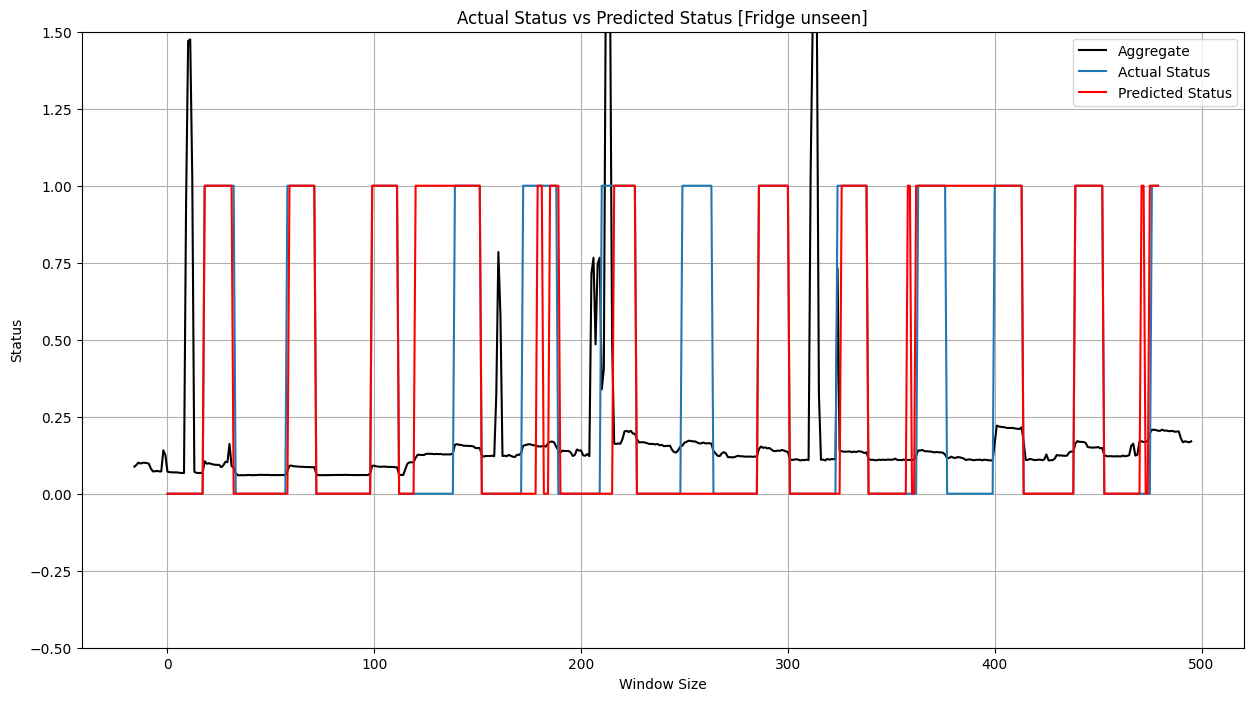

In [63]:
apply_test_status(dl_house_total[1], s_hats_unseen, 0, 'unseen', 10)

Break index: 10


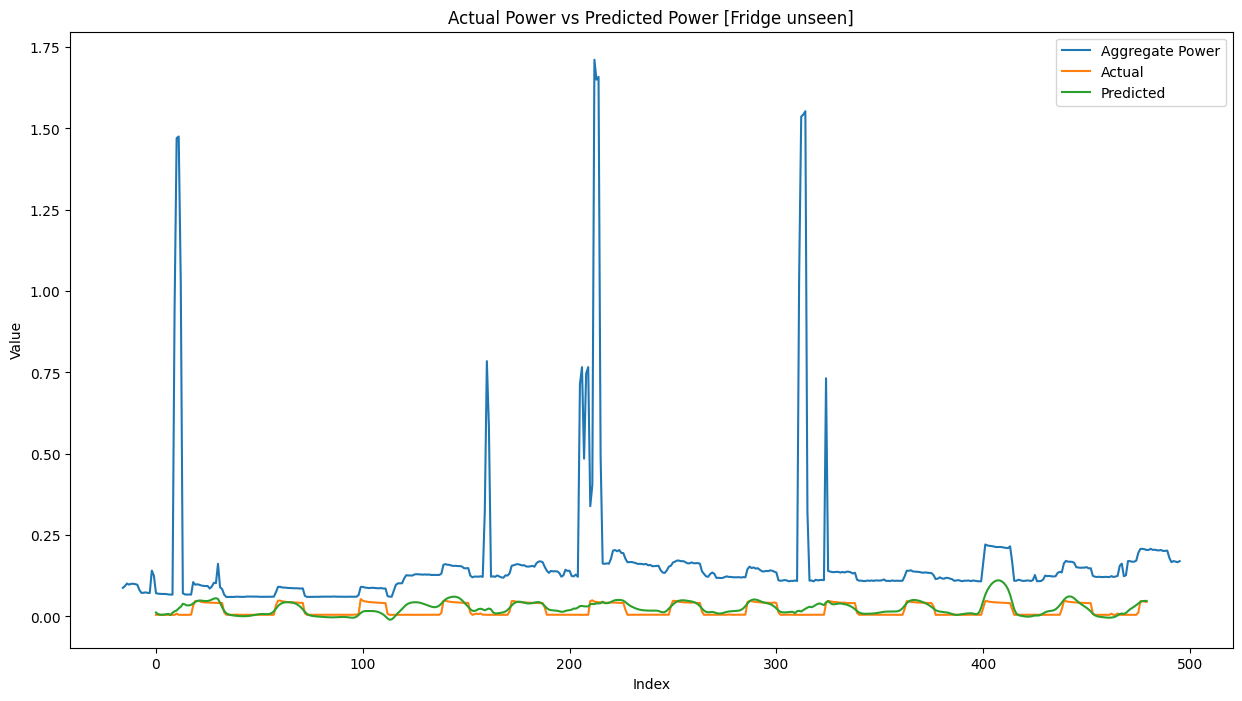

Total Aggregate Energy is 180.23kw/8h
Actual Energy Consumed by the Fridge is 19.04kw/8h
Predicted Energy Consumed by the Fridge is 25.03kw/8h


In [64]:
apply_test(dl_house_total[1], p_hat_appliances_unseen, 0, 10, 'unseen')

#### ***Dish Washer - UNSEEN CASE***

Break index: 11


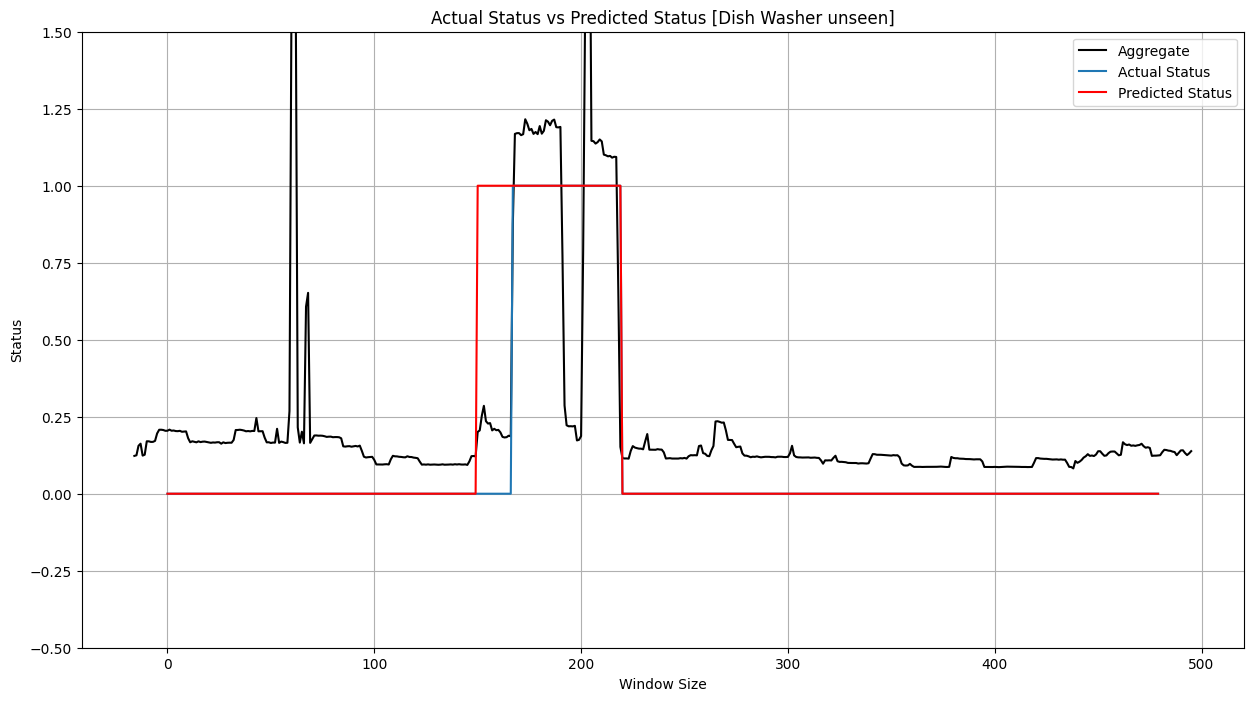

In [65]:
apply_test_status(dl_house_total[1], s_hats_unseen, 1, 'unseen', 10)

Break index: 11


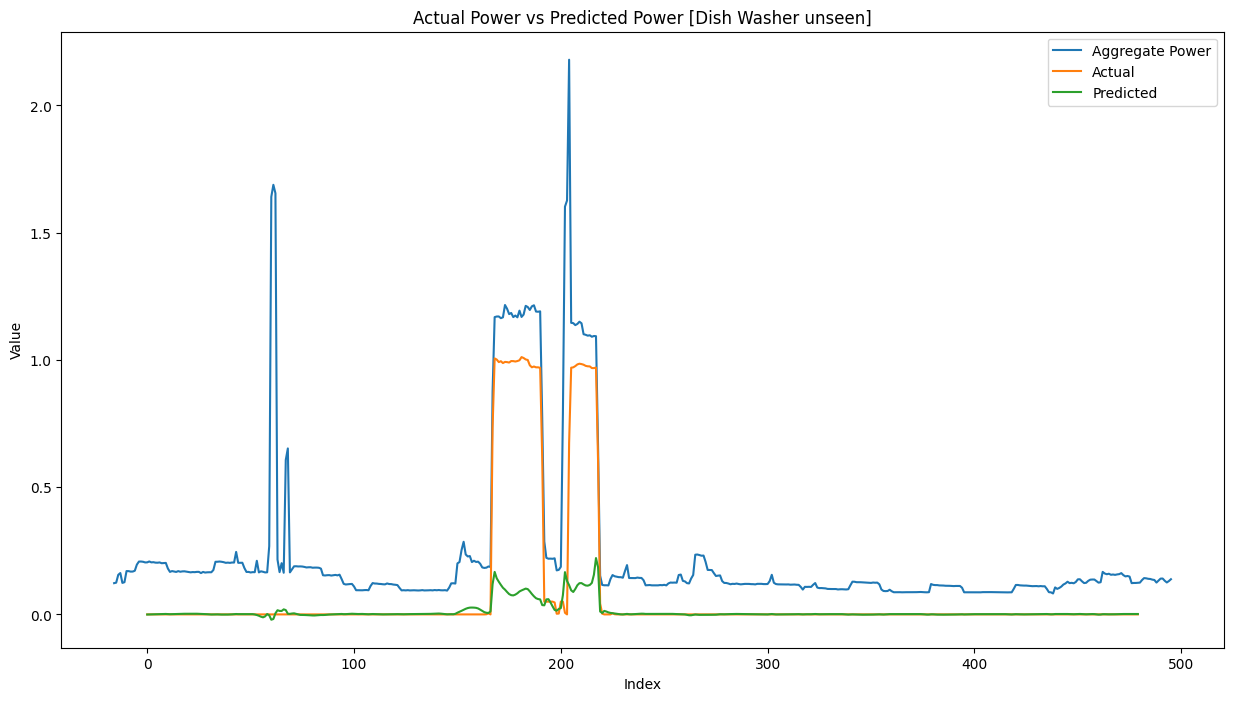

Total Aggregate Energy is 276.04kw/8h
Actual Energy Consumed by the Dish Washer is 77.12kw/8h
Predicted Energy Consumed by the Dish Washer is 11.03kw/8h


In [66]:
apply_test(dl_house_total[1], p_hat_appliances_unseen, 1, 10, 'unseen')

#### ***Washing Machine - UNSEEN CASE***

Break index: 13


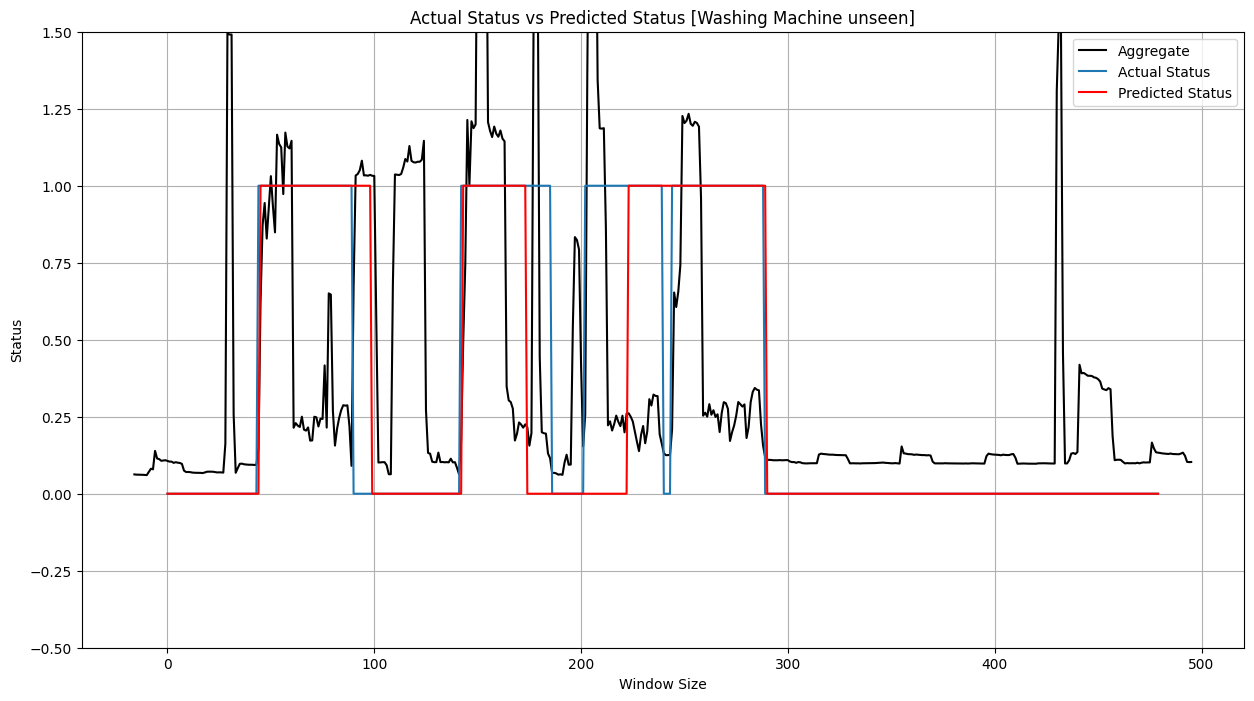

In [67]:
apply_test_status(dl_house_total[1], s_hats_unseen, 2, 'unseen', 10)

Break index: 13


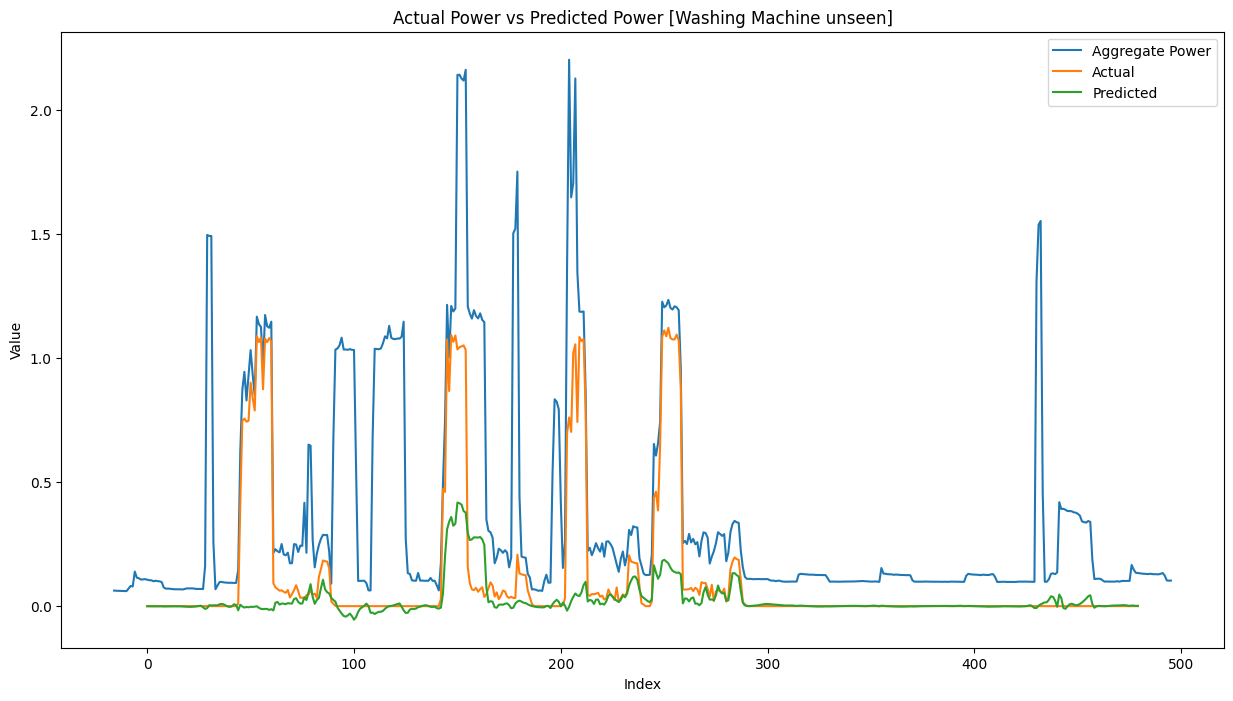

Total Aggregate Energy is 185.86kw/8h
Actual Energy Consumed by the Washing Machine is 112.36kw/8h
Predicted Energy Consumed by the Washing Machine is 25.13kw/8h


In [68]:
apply_test(dl_house_total[1], p_hat_appliances_unseen, 2, 10, 'unseen')

#### ***The Evaluation Metrics of POWER Prediction***

In [69]:
print(f"fridge\nMAE  :{mae['fridge']}\nMSE  :{mse['fridge']}\nRMSE  :{rmse['fridge']}\nR Squared  :{r_squared['fridge']}")
print(f"\ndish_washer\nMAE  :{mae['dish_washer']}\nMSE  :{mse['dish_washer']}\nRMSE  :{rmse['dish_washer']}\nR Squared  :{r_squared['dish_washer']}")
print(f"\nwashing_machine\nMAE  :{mae['washing_machine']}\nMSE  :{mse['washing_machine']}\nRMSE  :{rmse['washing_machine']}\nR Squared  :{r_squared['washing_machine']}")

fridge
MAE  :0.011578688398003578
MSE  :0.00026720258756540716
RMSE  :0.01634633168578148
R Squared  :0.20619404315948486

dish_washer
MAE  :0.07359108328819275
MSE  :0.060938797891139984
RMSE  :0.24685785174369812
R Squared  :0.12969970703125

washing_machine
MAE  :0.10277135670185089
MSE  :0.07412384450435638
RMSE  :0.2722569406032562
R Squared  :0.10540097951889038


#### ***The Evaluation Metrics of STATUS Prediction***

In [70]:
print(f"fridge\nF1 Score  :{f1_score_s['fridge']}\nPrecision  :{precision_s['fridge']}\nRecall  :{recall_s['fridge']}\nAccuracy  :{accuracy_s['fridge']}\nMCC  :{mcc_s['fridge']}")
print(f"\ndish_washer\nF1 Score  :{f1_score_s['dish_washer']}\nPrecision  :{precision_s['dish_washer']}\nRecall  :{recall_s['dish_washer']}\nAccuracy  :{accuracy_s['dish_washer']}\nMCC  :{mcc_s['dish_washer']}")
print(f"\nwashing_machine\nF1 Score  :{f1_score_s['washing_machine']}\nPrecision  :{precision_s['washing_machine']}\nRecall  :{recall_s['washing_machine']}\nAccuracy  :{accuracy_s['washing_machine']}\nMCC  :{mcc_s['washing_machine']}")

fridge
F1 Score  :0.7754010695187166
Precision  :0.7474226804123711
Recall  :0.8055555555555556
Accuracy  :0.825
MCC  :0.6335754305211765

dish_washer
F1 Score  :0.8617886178861789
Precision  :0.7571428571428571
Recall  :1.0
Accuracy  :0.9645833333333333
MCC  :0.8526423613214625

washing_machine
F1 Score  :0.8492307692307692
Precision  :0.9078947368421053
Recall  :0.7976878612716763
Accuracy  :0.8979166666666667
MCC  :0.7762481853292692
